# ディジタル信号

In [1]:
import os
import sys
import pyaudio
import numpy as np
import scipy as sp
import scipy.io.wavfile
import matplotlib.pyplot as plt
from IPython.display import Audio
%matplotlib inline

In [2]:
def plot_wave(time, amp, xtitle='Time[s]', ytitle='Amplitude[arb.]', hold=False, color='blue', marker=',', legend='', linestyle='-', stem=False):
    """
    波形プロット
    @Param time         : 時刻の離散データ
    @Param amplitude    : 時刻データに対応する瞬時振幅値
    @Param xtitle       : 横軸ラベル
    @Param ytitle       : 縦軸ラベル
    @Param hold         : False -> 描画, True -> データ保持
    @Param color        : グラフの色
    @Param marker       : マーカの種類
    @Param legend       : 凡例の文字列
    @Param linestyle    : 線の種類
    @Param stem         : False -> 折れ線グラフ, True -> ○付き棒グラフ
    """
    if (len(time) == 0):
        time = range(len(amp))
        if (xtitle == 'Time[s]'):
            xtitle = 'Time[point]'

    if (marker != ','):
        linestyle = ''

    if (stem == False):
        plt.plot(time, amp, color=color, marker=marker, linestyle=linestyle, label=legend)
    else:
        plt.stem(time, amp, label=legend, use_line_collection = True)

    if (legend != ''):
        plt.legend()

    if (hold == False):
        plt.xlabel(xtitle)
        plt.ylabel(ytitle)
        plt.show()

## ディジタル信号のフーリエ変換

継続時間がN点の離散時間信号$f(n)$は、DFT(Discrete Fourier Transform : 離散フーリエ変換)によってスペクトル $F(k)$ に変換できる。この変換によって得られるDFTスペクトル $F(k)$ は、N点の複素数からなる離散スペクトル。

$ F(k) = \Sigma^{N=1}_{n=0} f(n) e^{-j \frac{2\pi}{N}kn}$

DFTの計算量は、$O(n^2)$ (計算量オーダー)となる。

高速にDFTを行うFFT(Fast Fourier Transform : 高速フーリエ変換)では、$O(n \log n)$ となり、非常に計算量が少なくできる。

FFTを定義する。

In [3]:
def plot_FFT_spectrum(fft_result, fs=48000, level=False, plot_range=60):
    """
    @Param fft_result    : スペクトル結果
    @Param fs           : サンプリング周波数
    @Param level        : True -> 相対レベル表示
    @Param plot_range   : 縦軸範囲
    """
    amp = np.abs(fft_result)     # 振幅
    ph = np.angle(fft_result)    # 位相
    threshold = 10**(-plot_range/20) * max(amp) # 閾値(プロット範囲)
    ph[amp < threshold] = 0                     # 振幅が閾値より小さい場合は位相は0

    if (fs == None):
        freq = np.linspace(0, 2*np.pi, len(fft_result)+1)
        xtitle = 'Normarized angular frequency[rad]'
    else:
        freq = np.linspace(0, fs, len(fft_result)+1) # 基本周波数と高調波の周波数の配列
        xtitle = 'Frequency[Hz]'

    ''' 振幅スペクトル '''
    ytitle = 'Amplitude[arb.]'

    if (level == True):
        amp = amp + np.finfo(float).eps # 計算機イプシロンを加算
        amp = 20*np.log10(amp[0:len(fft_result)]/np.max(amp[0:len(fft_result)]))
        amp = amp + plot_range          # プロット範囲を加算
        amp[amp < 0] = 0                # plot_range未満は0
        ytitle = 'Relative level[dB]'

    plt.subplot(2, 1, 1)
    plt.stem(freq[0: len(fft_result)], amp)
    plt.xlabel(xtitle)
    plt.ylabel(ytitle)

    if (fs == None):
        plt.xticks([0, np.pi/2, np.pi, 3*np.pi/2, 2*np.pi], ["$0$", "0.5 $\pi$" ,"$\pi$", "$1.5 \pi$", "$2 \pi$"])

    if (level == True):
        plt.yticks([i for i in range(0, int(plot_range) + 1, 10)], [str(i) for i in range(-int(plot_range), 0+1, 10)])

    ''' 位相スペクトル '''
    ytitle = 'Phase[rad]'
    plt.subplot(2, 1, 2)
    plt.stem(freq[0: len(fft_result)], ph)
    plt.xlabel(xtitle)
    plt.ylabel(ytitle)
    plt.ylim(-np.pi, np.pi)
    plt.yticks([-np.pi, -np.pi/2, 0, np.pi/2, np.pi], ["$-\pi$", "$-\pi/2$" ,"0", "$\pi/2$", "$\pi$"])
    if (fs == None):
        plt.xticks([0, np.pi/2, np.pi, 3*np.pi/2, 2*np.pi], ["$0$", "0.5 $\pi$" ,"$\pi$", "$1.5 \pi$", "$2 \pi$"])
    plt.show()

"あ"の声をスペクトルしてみる。

Sampling frequency : 16000 [Hz]


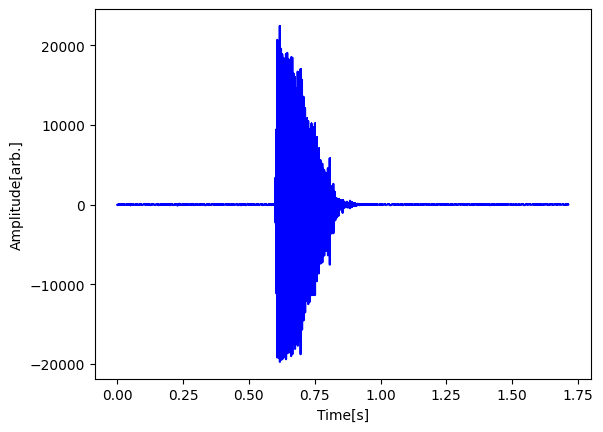

In [4]:
fs, wave_data = scipy.io.wavfile.read ('sample/sample_1.wav')
print('Sampling frequency :', fs, '[Hz]')
ts = 1/fs
dt = np.arange(len(wave_data))*ts
plot_wave(dt, wave_data)

audio = Audio(wave_data, rate=fs)
audio

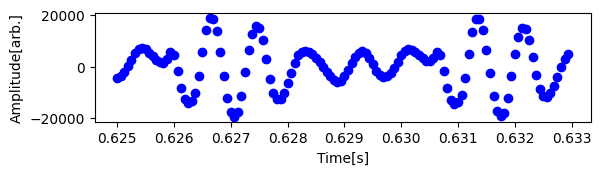

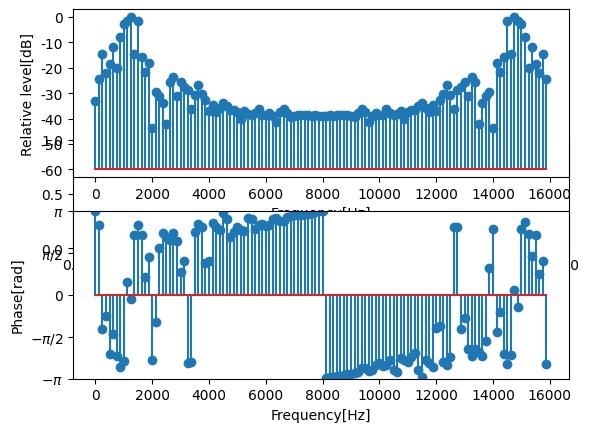

In [5]:
sampling_point = 128        # プロットするサンプリング点
start = 10000               # プロットする開始サンプリング点
end = start+sampling_point  # プロットの終了サンプリング点
plt.subplot(3,1,1)
plot_wave(dt[start:end], wave_data[start:end], marker='o')
fft_result = np.fft.fft(wave_data[start:end])
plt.subplot(3,1,2)
plot_FFT_spectrum(fft_result, fs, level=True)

振幅スペクトルで、母音を特徴づけるフォルマントを確認することができた。位相スペクトルでは、特徴らしい特徴はない。また、サンプリング周波数は、16[kHz]なので、標本化定理を満たすのは8[kHz]である。この場合の振幅スペクトルの8[kHz]以上の成分がどうなるのかを考えてみる。

まず、32[Hz]で1[s]のサンプリング波形を見てみる。標本化定理により、ナイキスト周波数は16[Hz]。周波数1[Hz]で振幅1のcos波をサンプリングしたサンプリング値をFFTし、スペクトルをプロットしてみる。

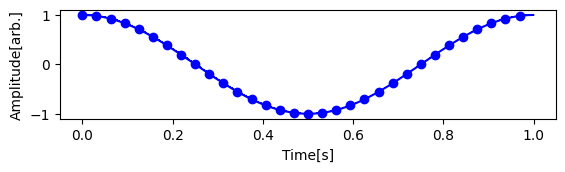

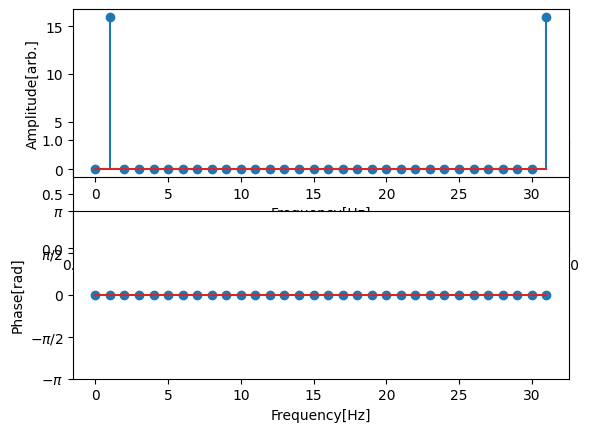

In [6]:
fs = 32 # サンプリング周波数
f0 = 1  # 基本周波数
A  = 1  # 振幅
t = np.arange(0, 1, 1/fs)
fn = A*np.cos(2*np.pi*f0*t)
fft_result = np.fft.fft(fn)

# 疑似アナログ波形
fs_a = 1000
t_a = np.arange(0, 1, 1/fs_a)
fn_a = A*np.cos(2*np.pi*f0*t_a)

plt.subplot(3,1,1)
plot_wave(t_a, fn_a, hold=True) # 疑似アナログデータ(プロットせず保持)
plot_wave(t, fn, marker='o')    # ディジタルデータ
plt.subplot(3,1,2)
plot_FFT_spectrum(fft_result, fs)

プロットされた図を見ると、振幅スペクトルでちゃんと1[Hz]の成分があり、cos波なので位相が0となっている。一方で、振幅スペクトルに31[Hz]の成分があり、本来は0.5であるべき1[Hz]の振幅値が16となっている。

基本周波数3[Hz]に変えて見てみる。

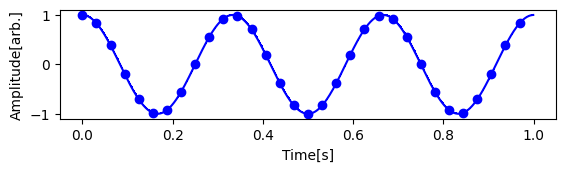

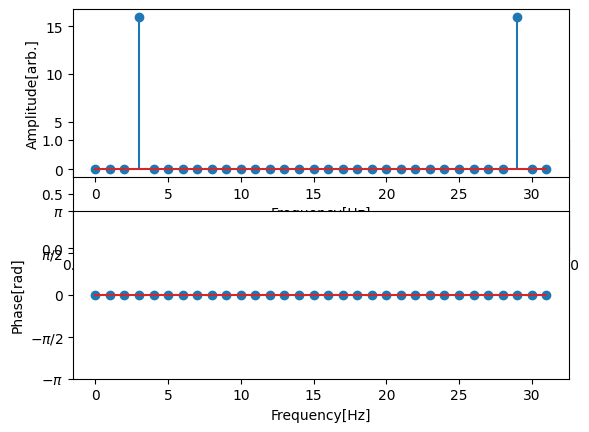

In [7]:
fs = 32 # サンプリング周波数
f0 = 3  # 基本周波数
A  = 1  # 振幅
t = np.arange(0, 1, 1/fs)
fn = A*np.cos(2*np.pi*f0*t)
fft_result = np.fft.fft(fn)

# 疑似アナログ波形
fs_a = 1000
t_a = np.arange(0, 1, 1/fs_a)
fn_a = A*np.cos(2*np.pi*f0*t_a)

plt.subplot(3,1,1)
plot_wave(t_a, fn_a, hold=True) # 疑似アナログデータ(プロットせず保持)
plot_wave(t, fn, marker='o')    # ディジタルデータ
plt.subplot(3,1,2)
plot_FFT_spectrum(fft_result, fs)

基本周波数6[Hz]に変えて見てみる。

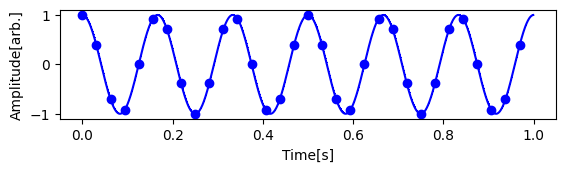

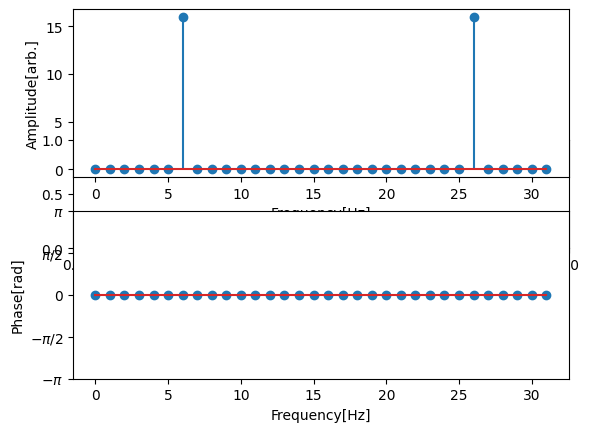

In [8]:
fs = 32 # サンプリング周波数
f0 = 6  # 基本周波数
A  = 1  # 振幅
t = np.arange(0, 1, 1/fs)
fn = A*np.cos(2*np.pi*f0*t)
fft_result = np.fft.fft(fn)

# 疑似アナログ波形
fs_a = 1000
t_a = np.arange(0, 1, 1/fs_a)
fn_a = A*np.cos(2*np.pi*f0*t_a)

plt.subplot(3,1,1)
plot_wave(t_a, fn_a, hold=True) # 疑似アナログデータ(プロットせず保持)
plot_wave(t, fn, marker='o')    # ディジタルデータ
plt.subplot(3,1,2)
plot_FFT_spectrum(fft_result, fs)

基本周波数15[Hz]に変えて見てみる。

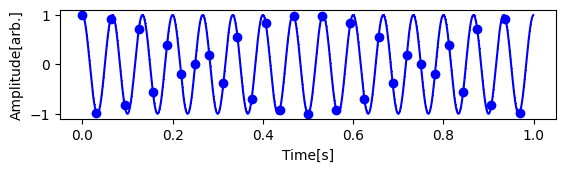

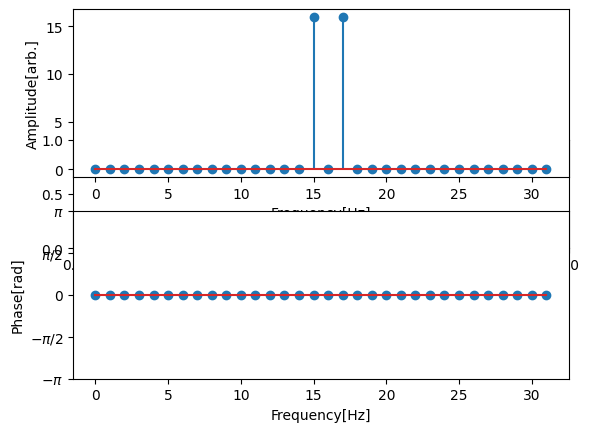

In [9]:
fs = 32 # サンプリング周波数
f0 = 15 # 基本周波数
A  = 1  # 振幅
t = np.arange(0, 1, 1/fs)
fn = A*np.cos(2*np.pi*f0*t)
fft_result = np.fft.fft(fn)

# 疑似アナログ波形
fs_a = 1000
t_a = np.arange(0, 1, 1/fs_a)
fn_a = A*np.cos(2*np.pi*f0*t_a)

plt.subplot(3,1,1)
plot_wave(t_a, fn_a, hold=True) # 疑似アナログデータ(プロットせず保持)
plot_wave(t, fn, marker='o')    # ディジタルデータ
plt.subplot(3,1,2)
plot_FFT_spectrum(fft_result, fs)

やはり、どれも振幅スペクトルでちゃんと基本周波数の成分があり、cos波なので位相が0となっている一方で、振幅スペクトルで基本周波数と対象となるようなに別の成分があり、本来は0.5であるべき振幅値が16となっている。

まず、基本周波数$f_0$の値を高くしていくと、対象となるような別の成分の周波数は規則的に低くなっていく。これは、複素フーリエ級数展開のスペクトルで、正の周波数成分$nf_0$[Hz]のペアとして、負の周波数成分$-nf_0$が必ずあることが関係している。波形をサンプリングすると、スペクトルは$f_s$ごとに周期化する性質があり、この基本周波数の成分とは別の成分は、負の周波数成分が$f_s = 32$[Hz]を出発点に発生する。この別の成分は、本来欲しい成分の複素数の虚部をキャンセルする役割があることから必須のもの。

※実数の波形$f(n)$を、$C_n e^{j2\pi nf_0 t}$という複素正弦波を使って表す。この複素正弦波から実数を取り出すためには、その虚数部分をキャンセルする必要があり、そのために複素共役である$\hat C_n e^{-j2\pi nf_0 t}$を用意し、これを負の周波数成分と表現している。

ここまでは、時間波形$f(n)$からスペクトル$F(n)$を求めるDFTを利用したが、次はスペクトル$F(n)$から時間波形$f(n)$に戻すIDFT(Inverse discrete Fourier Transform : 逆フーリエ変換)も併用して考えてみる。

$ F(k) = \Sigma^{N-1}_{n=0} f(n) e^{-j\frac{2\pi}{N}kn} $

$ f(n) = \frac{1}{N}\Sigma^{N-1}_{k=0} F(k) e^{j\frac{2\pi}{N}kn} $

1[Hz]の波と31[Hz]の波だけがある状態は、$k=1$と$k=31$の2つの波がある状態なので、IDFTの式を使って次のように表すことができる。

$ f(n) = \frac{1}{32} \{ F(1)e^{j\frac{2\pi}{32}n} + F(31)e^{j\frac{2\pi}{32}31n} \}$

ただし、プロットされたスペクトルを見てわかる通り、絶対値が16で、偏角が0の複素数で$F(1) = 16e^{-j0}$となるので、偏角0で16の実数となる。F(31)も同様に16なので、これらを上式に代入すると、次のようになる。

$ f(n) = \frac{1}{2} \{ e^{j(2\pi 1 \frac{n}{32})} + e^{j(2\pi 31 \frac{n}{32})} \} $

上式の右辺の2項は、それぞれ1[Hz]と31[Hz]の複素正弦波を標本化した系列。ただし、$ 2\pi ft $の $ t $の代わりに$ n/32 $とし、$n$が増えると1/32[s]ごとに時間軸を離散的に進んでいく。

そこで、オイラーの定理 $ e^{j2\pi ft} = \cos(2\pi ft) + j\sin(2 \pi ft) $ より、実部と虚部にわけてプロットしてみる。

実部をプロット

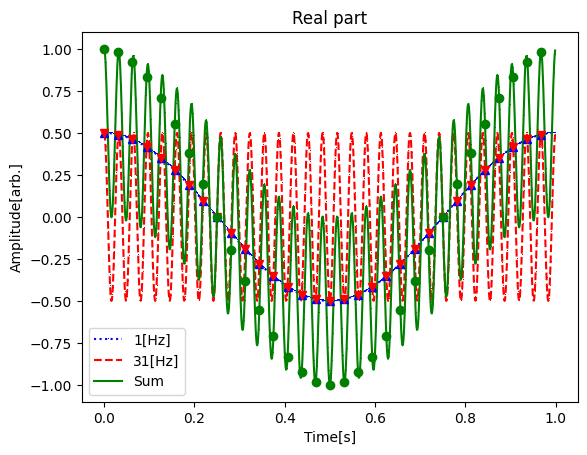

In [10]:
f1 = 1
f2 = 31
A = 0.5  # 振幅は1/2

''' 実部をプロット '''
# アナログ波形(疑似)生成
fs_a = 1000 # サンプリング周波数
t_a = np.arange(0, 1, 1/fs_a)
f1t_a = A*np.cos(2*np.pi*f1*t_a)
f2t_a = A*np.cos(2*np.pi*f2*t_a)
f3t_a = f1t_a + f2t_a

plt.figure()
plt.title('Real part')
plot_wave(t_a, f1t_a, hold=True, color='b', legend='1[Hz]', linestyle=':')
plot_wave(t_a, f2t_a, hold=True, color='r', legend='31[Hz]', linestyle='--')
plot_wave(t_a, f3t_a, hold=True, color='g', legend='Sum')

# 32[Hz]の標本化系列
fs = 32
t = np.arange(0, 1, 1/fs)
f1t = A*np.cos(2*np.pi*f1*t)
f2t = A*np.cos(2*np.pi*f2*t)
f3t = f1t + f2t

plot_wave(t, f1t, hold=True, color='b', marker='^')
plot_wave(t, f2t, hold=True, color='r', marker='v')
plot_wave(t, f3t, color='g', marker='o')

実部の方は、1[Hz]の波を1/32[s]でサンプリングした青△と31[Hz]の波を1/32[s]でサンプリングした赤▽が完全に一致しているのがわかる。一方で、両波形(cos波)を合成した波形を同様に1/32[s]でサンプリングした緑〇は周波数[Hz]で振幅が1のcos波となっている。

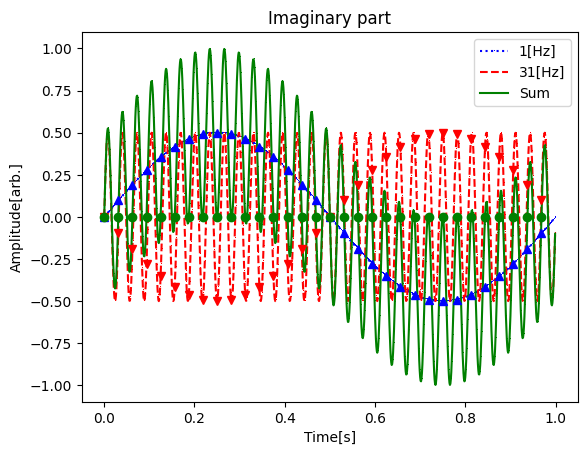

In [11]:
''' 虚部をプロット '''
plt.figure()
f1t_a = A*np.sin(2.0*np.pi*f1*t_a)
f2t_a = A*np.sin(2.0*np.pi*f2*t_a)
f3t_a = f1t_a + f2t_a

plt.title('Imaginary part')
plot_wave(t_a, f1t_a, hold=True, color='b', legend='1[Hz]', linestyle=':')
plot_wave(t_a, f2t_a, hold=True, color='r', legend='31[Hz]', linestyle='--')
plot_wave(t_a, f3t_a, hold=True, color='g', legend='Sum')

f1t = A*np.sin(2*np.pi*f1*t)
f2t = A*np.sin(2*np.pi*f2*t)
f3t = f1t + f2t

plot_wave(t, f1t, hold=True, color='b', marker='^')
plot_wave(t, f2t, hold=True, color='r', marker='v')
plot_wave(t, f3t, color='g', marker='o')

虚部の方は、1[Hz]の波を1/32[s]でサンプリングした青△と31[Hz]の波を1/32[s]でサンプリングした赤▽が完全に正負が逆転しているのがわかる。一方で、両波形(sin波)を合成した波形を同様に1/32[s]でサンプリングした緑〇は、0が続いている。つまり、虚部がキャンセルされてるということ。

まとめると、実数の波を複素正弦波で表現するには、複素正弦波の虚部をキャンセルする必要があり、そのためにはスペクトルの半分の成分である負の周波数またはナイキスト周波数以上の成分は、ナイキスト周波数以下の正の周波数成分の共役複素数がなくてはならない。



実部はcos波、虚部はsin波だったが、実部をsin波、虚部をcos波に入れ替えて考えてみる。

オイラーの定理 $e^{j (2 \pi f t -\pi/2)} = \cos (2 \pi f t -\pi/2) + j \sin(2 \pi f t -\pi/2)$, $e^{j (2 \pi f t + \pi/2)} = \cos (2 \pi f t +\pi/2) + j \sin(2 \pi f t + \pi/2)$を利用し、実部と虚部を分けてプロットする。実際には、$e^{j (2 \pi f t -\pi/2)} = \sin (2 \pi f t ) - j \cos(2 \pi f t)$, $e^{j (2 \pi f t + \pi/2)} = - \sin (2 \pi f t) + j \cos(2 \pi f t + \pi/2)$ とし、実部と虚部をプロットする。

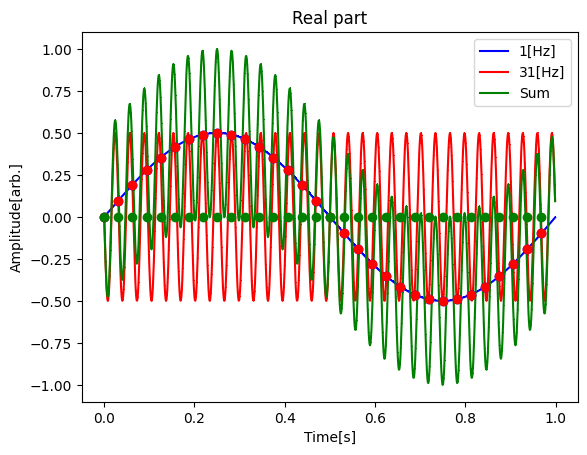

In [12]:
f1 = 1
f2 = 31
A = 0.5 # 振幅は1/2

''' 実部をプロット '''
plt.figure()
fs_a = 1000
t_a = np.arange(0, 1, 1/fs_a)
p1t_a =  A*np.sin(2*np.pi*f1*t_a)
p2t_a = -A*np.sin(2*np.pi*f2*t_a)
p3t_a = p1t_a + p2t_a

plt.title('Real part')
plot_wave(t_a, p1t_a, hold=True, color='b', legend= '1[Hz]')
plot_wave(t_a, p2t_a, hold=True, color='r', legend= '31[Hz]')
plot_wave(t_a, p3t_a, hold=True, color='g', legend= 'Sum')

fs = 32
t = np.arange(0, 1, 1/fs)
p1t =  A*np.sin(2*np.pi*f1*t)
p2t = -A*np.sin(2*np.pi*f2*t)
p3t = f1t + f2t

plot_wave(t, p1t, hold=True, color='b', marker='o')
plot_wave(t, p2t, hold=True, color='r', marker='o')
plot_wave(t, p3t, color='g', marker='o')

実部の方は、1[Hz]の波を1/32[s]でサンプリングした青△と31[Hz]の波を1/32[s]でサンプリングした赤▽が完全に一致しているのがわかる。一方で、両波形(cos波)を合成した波形を同様に1/32[s]でサンプリングした緑〇は周波数[Hz]で振幅が1のsin波となっている。

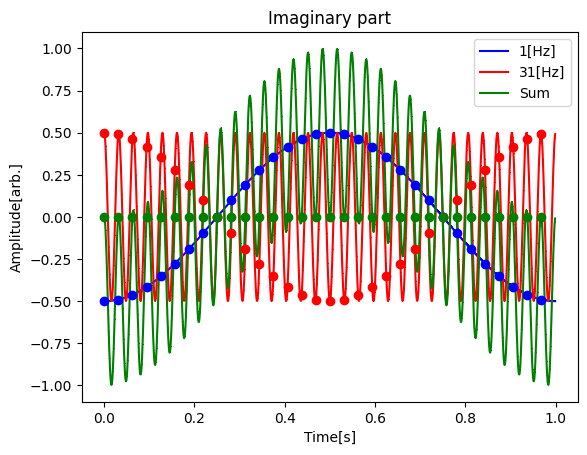

In [13]:
''' 虚部をプロット '''
plt.figure()
p1t_a = -A*np.cos(2*np.pi*f1*t_a)
p2t_a = A*np.cos(2*np.pi*f2*t_a)
p3t_a = p1t_a + p2t_a

plt.title('Imaginary part')
plot_wave(t_a, p1t_a, hold=True, color='b', legend='1[Hz]')
plot_wave(t_a, p2t_a, hold=True, color='r', legend='31[Hz]')
plot_wave(t_a, p3t_a, hold=True, color='g', legend='Sum')

p1t = -A*np.cos(2*np.pi*f1*t)
p2t = A*np.cos(2*np.pi*f2*t)
p3t = p1t + p2t

plot_wave(t, p1t, hold=True, color='b', marker='o')
plot_wave(t, p2t, hold=True, color='r', marker='o')
plot_wave(t, p3t, color='g', marker='o')

虚部の方は、1[Hz]の波を1/32[s]でサンプリングした青△と31[Hz]の波を1/32[s]でサンプリングした赤▽が完全に正負が逆転しているのがわかる。一方で、両波形(cos波)を合成した波形を同様に1/32[s]でサンプリングした緑〇は、0が続いている。やはり、虚部がキャンセルされてる。

次に、本来は振幅1の波形の場合、振幅が1/2で出力されるはずだが、振幅値が16で出力されていたことについてを考えてみる。

これは、DFTとIDFTの式から考える。

$ DFT : F(k) = \Sigma^{N-1}_{n=0} f(n) e^{-j\frac{2\pi}{N}kn} $

$ IDFT : f(n) = \frac{1}{N}\Sigma^{N-1}_{k=0} F(k) e^{j\frac{2\pi}{N}kn} $

上記のIDFYの式の係数 $ \frac{1}{N} $を、下記のようにDFTに入れ替えて考える。

$ F(k) = \frac{1}{N}\Sigma^{N-1}_{n=0} f(n) e^{-j\frac{2\pi}{N}kn} $

$ f(n) = \Sigma^{N-1}_{k=0} F(k) e^{j\frac{2\pi}{N}kn} $

これで、振幅が 1 のcos波をFFTすると得られる振幅値は、16 の代わりに $16/32=1/2$ となる。これは、複素スペクトルの振幅値は、実スペクトルの振幅値の 1/2 となり、これは負の周波数成分と半分ずつ分け合っているのと同じである。しかし、実際は最大値が 16 でも 1/2 でも相対レベルで計算すればどちらも 0[dB] となるので式は係数 $ 1/N $ を入れ替えずに定義された式のままでも問題はない。つまり、すべての成分に共通して掛かる係数は無視しても問題ない。これは、音で考えるとわかる。音を再生して聞く場合、聞きやすいボリュームを調整するため、スペクトルとして共通係数を保存していても意味がない。つまり、ボリュームを調整しても音の音色自体に影響はないのと同じこと。これは、音の本質は振幅そのものの大きさではなく、相対レベルであるスペクトルの形そのものにあるからである。よって、係数 $ 1/N $ はDFTから省略されている。ただし、逆DFTした際に元の振幅値の波形に戻らないと、他の信号と併せて処理する際に不都合が生じるため、逆DFTには係数 $ 1/N $ がある。

次に、ディジタル信号のスペクトルについて考える。

ディジタル信号のスペクトルにおいて、隣り合う成分同士の間隔のことを**周波数ビン**または**周波数分解能**といい、次のように表すことができる。

$ \Delta f = \frac{f_s}{N} $

$ f_s $ : サンプリング周波数、$ N $ : サンプリング点数

例として、サンプリング周波数 44.1[kHz] でサンプリングされた、N=1024点の信号をFFTした場合の周波数ビンは、$ \Delta f = 44.1 \times 10^3 / 1024 = 43.066 $ [Hz]となる。このように、周波数ビンは**整数にはならない**。

また、ディジタル信号においては、サンプリングされた信号の横軸は、時間[s]ではなくサンプリング番号で単位は無次元となる。例えば、$1$[Hz] のsin波を $ f_s=100 $[Hz] でサンプリングしたディジタル信号と、$10$[Hz]のsin波を $ f_s = 1000 $[Hz]でサンプリングしたディジタル信号は、全く同じものになる。従って、波形の横軸は時間[s]する必要はなく、スペクトルの横軸を周波数[Hz]とする必要もない。

試しに、周波数1[Hz]、振幅1のcos波をサンプリング周波数32[Hz]でサンプリングしたディジタル信号をFFTし、スペクトルをプロットしてみる。

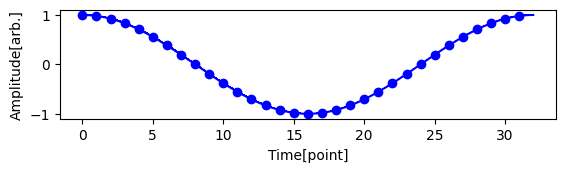

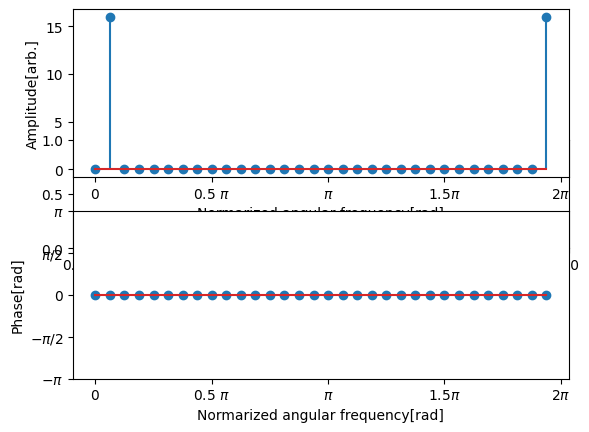

In [14]:
fs = 32                     # サンプリング周波数[Hz]
f0 = 1                      # 基本周波数[Hz]
A = 1                       # 振幅値
t = np.arange(0, 1, 1/fs)   # サンプリング点の配列
fn = A*np.cos(2*np.pi*f0*t) # 標本値
fft_result = np.fft.fft(fn)

# アナログ波形(疑似)
plt.subplot(3,1,1)
fs_a = 100
t_a = np.arange(0, fs, 1/fs_a)
fn_a = A*np.cos(2*np.pi*f0/fs*t_a)
plot_wave(t_a, fn_a, hold = True)
# ディジタル波形
plot_wave([], fn, marker = 'o')

plt.subplot(3,1,2)
plot_FFT_spectrum(fft_result, fs=None) # None -> 横軸が正規化角周波数

プロットされた波形の横軸は、サンプリング点の番号であり、無次元の量となっている。スペクトルの横軸は、**正規化角周波数**となっている。基本周波数は、 $f_0 = 1$[Hz]としているため、32点で1周期($2\pi$)だけ回るという波形になっている。従って、正規化角周波数は $2\pi(1/32) = \pi/16$[rad/s]。例えば、$f_0 = 8$ とすると、32点で8周期($16\pi$)だけ回るため、正規化角周波数は、 $2\pi(8/32) = \pi/2$[rad/s]となる。つまり、スペクトルの横軸上のk番目の波は、$N$ 点で $k$ 周期だけ回る波である(ただし、0番目は直流成分なので、0回しか回らない)。

$ DFT : F(k) = \Sigma^{N-1}_{n=0} f(n) e^{-j\frac{2\pi}{N}kn} $

$ IDFT : f(n) = \frac{1}{N}\Sigma^{N-1}_{k=0} F(k) e^{j\frac{2\pi}{N}kn} $

離散フーリエ変換では、$e^{-j\frac{2\pi}{N}kn}$ 項の指数部分を $ 2\pi k(n/N) $ とすることでアナログ波形の $ 2\pi ft $ 、つまり、アナログの $ t $ をディジタルの $ n / N $ に対応づけて考えた。アナログ波形の $ 2\pi ft $ を $ 2\pi f(t/1) $ と変形すると、$ t=1 $ [s]間で $f$ 周期だけ回る波で、ディジタルの場合は、 $ n = N$ で $k$ 周期だけ回る。その結果、アナログの角周波数 $\Omega = 2\pi ft$ は、ディジタルでは角周波数が $ 2\pi(k/N) $ となっている。

## 窓関数

前回は、サンプリング周波数32[Hz]、サンプリング点数N=32点のディジタル信号を例にとり、周波数ビン $f_s / N = 1$ [Hz]で1[Hz]の整数倍の周波数だけを取り上げていたため、すべて周波数ビンに載る周波数であり、綺麗に1[s]で元に戻った。そこで、周波数ビンに載らないような波形を考えてみる。

試しに、基本周波数 $ f_0 = 2.5 $ [Hz]の正弦波をプロットしてみる。

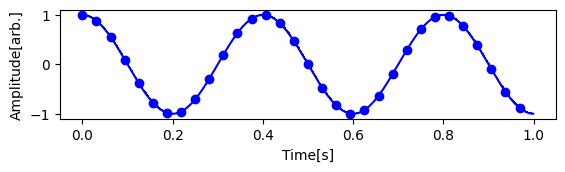

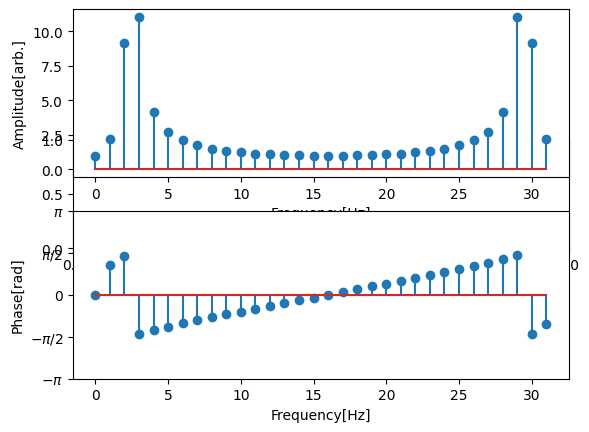

In [15]:
fs = 32                     # サンプリング周波数
f0 = 2.5                    # 基本周波数
A  = 1                      # 振幅
t = np.arange(0, 1, 1/fs)   # 1[s]のサンプリング点
fn = A*np.cos(2*np.pi*f0*t) # サンプリング値
sp = np.fft.fft(fn)

plt.subplot(3,1,1)
# アナログ波形(疑似)
fs_a = 1000
t_a = np.arange(0, 1, 1/fs_a)
fn_a = A*np.cos(2*np.pi*f0*t_a)
# ディジタル波形
plot_wave(t_a, fn_a, hold=True)
plot_wave(t, fn, marker='o')

plt.subplot(3,1,2)
plot_FFT_spectrum(sp, fs)

波形の図において、サンプリング値が綺麗に並んでいないのがわかる。また、スペクトルでは、2.5[Hz]なので2[Hz]と3[Hz]における振幅が大きくなっている。しかし、それ以外の周波数成分も振幅の値が0でない。

他の周波数でも試してみる。基本周波数 $ f_0 = 1.3 $ [Hz]の正弦波をプロットする。

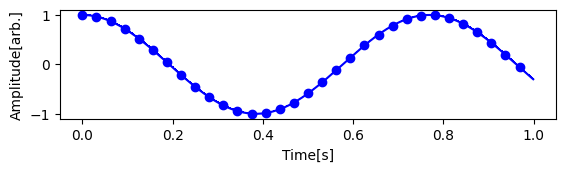

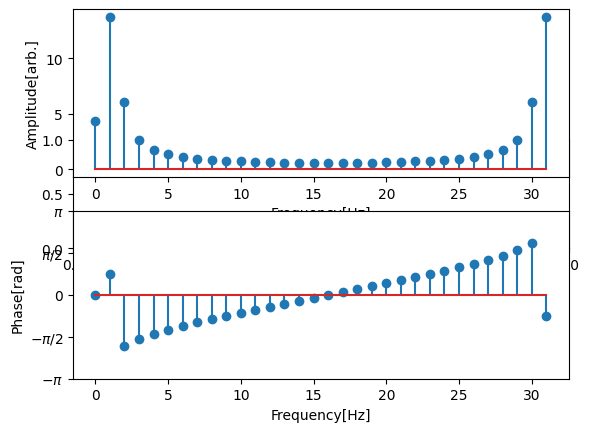

In [16]:
fs = 32                     # サンプリング周波数
f0 = 1.3                    # 基本周波数
A  = 1                      # 振幅
t = np.arange(0, 1, 1/fs)   # 1[s]のサンプリング点
fn = A*np.cos(2*np.pi*f0*t) # サンプリング値
sp = np.fft.fft(fn)

plt.subplot(3,1,1)
# アナログ波形(疑似)
fs_a = 1000
t_a = np.arange(0, 1, 1/fs_a)
fn_a = A*np.cos(2*np.pi*f0*t_a)
# ディジタル波形
plot_wave(t_a, fn_a, hold=True)
plot_wave(t, fn, marker='o')

plt.subplot(3,1,2)
plot_FFT_spectrum(sp, fs)

基本周波数 $ f_0 = 2.5 $ [Hz]と同様の現象が確認できる。

次は、基本周波数 $ f_0 = 2.7 $ [Hz]の正弦波をプロットしてみる。

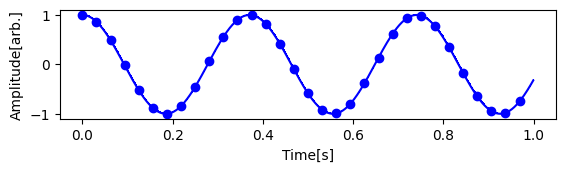

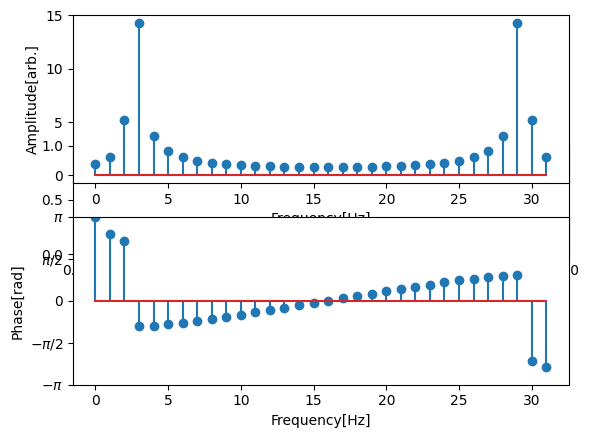

In [17]:
fs = 32                     # サンプリング周波数
f0 = 2.7                    # 基本周波数
A  = 1                      # 振幅
t = np.arange(0, 1, 1/fs)   # 1[s]のサンプリング点
fn = A*np.cos(2*np.pi*f0*t) # サンプリング値
sp = np.fft.fft(fn)

plt.subplot(3,1,1)
# アナログ波形(疑似)
fs_a = 1000
t_a = np.arange(0, 1, 1/fs_a)
fn_a = A*np.cos(2*np.pi*f0*t_a)
# ディジタル波形
plot_wave(t_a, fn_a, hold=True)
plot_wave(t, fn, marker='o')

plt.subplot(3,1,2)
plot_FFT_spectrum(sp, fs)

次は、基本周波数 $ f_0 = 3.1 $ [Hz]の正弦波をプロットしてみる。

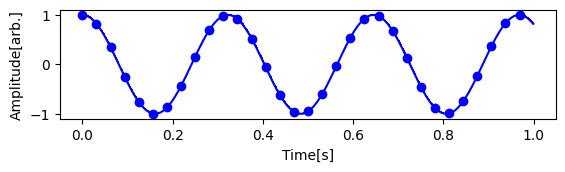

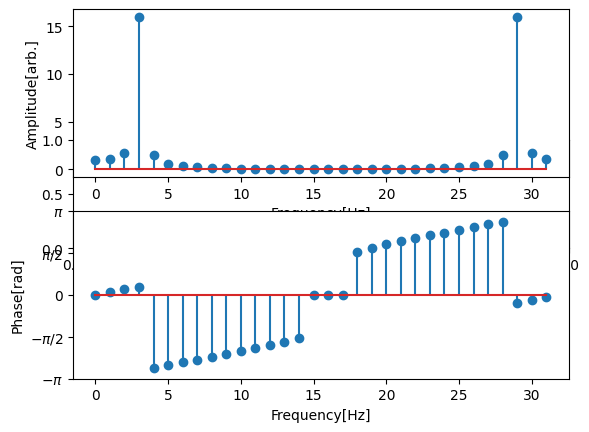

In [18]:
fs = 32                     # サンプリング周波数
f0 = 3.1                    # 基本周波数
A  = 1                      # 振幅
t = np.arange(0, 1, 1/fs)   # 1[s]のサンプリング点
fn = A*np.cos(2*np.pi*f0*t) # サンプリング値
sp = np.fft.fft(fn)

plt.subplot(3,1,1)
# アナログ波形(疑似)
fs_a = 1000
t_a = np.arange(0, 1, 1/fs_a)
fn_a = A*np.cos(2*np.pi*f0*t_a)
# ディジタル波形
plot_wave(t_a, fn_a, hold=True)
plot_wave(t, fn, marker='o')

plt.subplot(3,1,2)
plot_FFT_spectrum(sp, fs)

次は、基本周波数 $ f_0 = 3 $ [Hz]の正弦波をプロットしてみる。

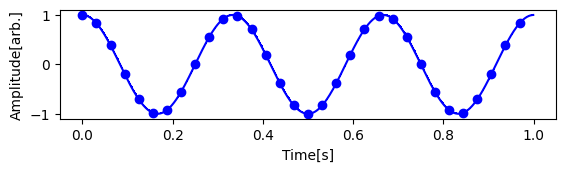

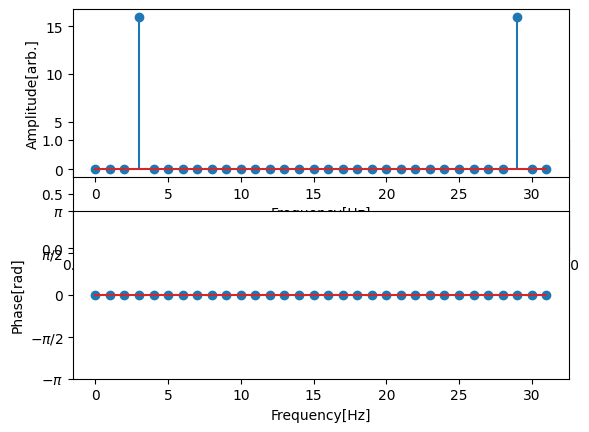

In [19]:
fs = 32                     # サンプリング周波数
f0 = 3                      # 基本周波数
A  = 1                      # 振幅
t = np.arange(0, 1, 1/fs)   # 1[s]のサンプリング点
fn = A*np.cos(2*np.pi*f0*t) # サンプリング値
sp = np.fft.fft(fn)

plt.subplot(3,1,1)
# アナログ波形(疑似)
fs_a = 1000
t_a = np.arange(0, 1, 1/fs_a)
fn_a = A*np.cos(2*np.pi*f0*t_a)
# ディジタル波形
plot_wave(t_a, fn_a, hold=True)
plot_wave(t, fn, marker='o')

plt.subplot(3,1,2)
plot_FFT_spectrum(sp, fs)

どうやら小数点1位の値が0に近くなればなるほど、基本周波数以外の周波数成分の振幅が抑えらる。これは、FFTでは、切り出した波形を無理矢理繰り返すと考えた波形が分析の対象となっているからである。波形が周期的であれば、スペクトルは離散的になるという性質を利用している。この性質はフーリエ級数展開で確認できる。

例として、2.5[Hz]の波形を無理矢理、4周期繰り返してみる。

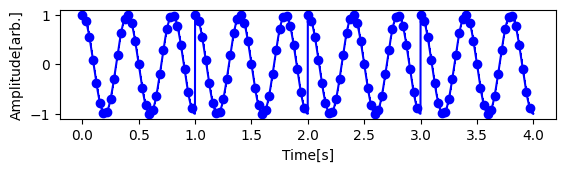

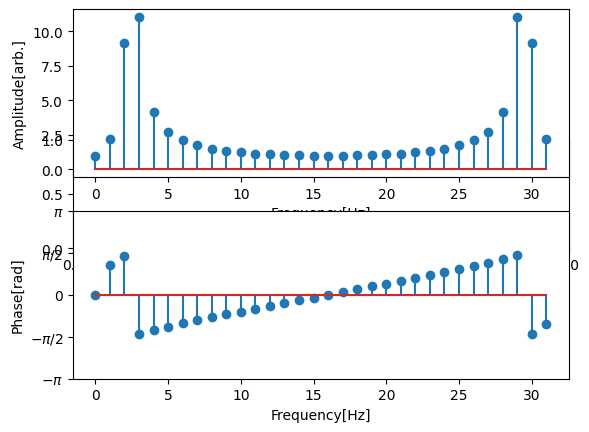

In [20]:
fs = 32                     # サンプリング周波数
f0 = 2.5                    # 基本周波数
t = np.arange(0, 1, 1/fs)   # 1[s]のサンプリング点
fn = A*np.cos(2*np.pi*f0*t) # サンプリング値の配列
sp = np.fft.fft(fn)

# アナログ波形(疑似)
fs_a = 1000
t_a = np.arange(0, 1, 1/fs_a)
fn_a = A*np.cos(2*np.pi*f0*t_a)

# 無理矢理4周期分繰り返す
for i in range(1, 3):
    t = np.append(t, t+float(i))
    fn = np.append(fn, fn)
    t_a = np.append(t_a, t_a+float(i))
    fn_a = np.append(fn_a, fn_a)

plt.subplot(3,1,1)
plot_wave(t_a, fn_a, hold=True)
plot_wave(t, fn, marker='o')

plt.subplot(3,1,2)
plot_FFT_spectrum(sp, fs)

波形の図を見てみると明らかな不連続点が確認できる。これは、フーリエ級数展開で、方形波のように不連続点がある場合に、振幅スペクトルが高い周波数まで広がっていたのと同様のことである。

他の周波数でも試してみる。まず、基本周波数を1.3[Hz]で試してみる。

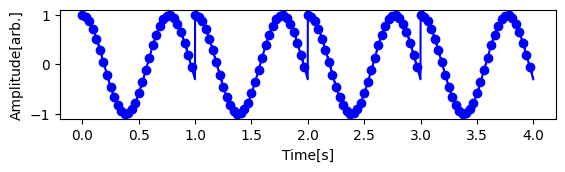

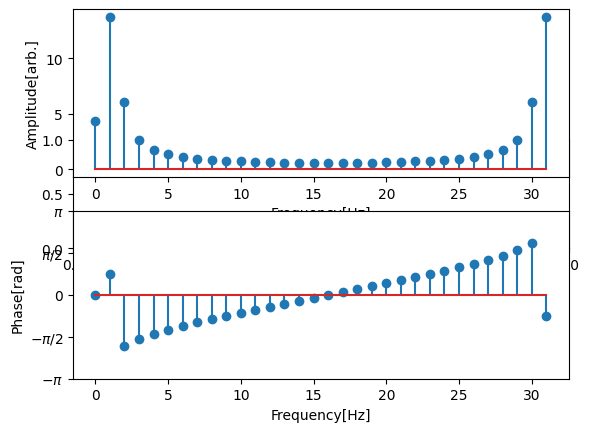

In [21]:
fs = 32                     # サンプリング周波数
f0 = 1.3                    # 基本周波数
t = np.arange(0, 1, 1/fs)   # 1[s]のサンプリング点
fn = A*np.cos(2*np.pi*f0*t) # サンプリング値の配列
sp = np.fft.fft(fn)

# アナログ波形(疑似)
fs_a = 1000
t_a = np.arange(0, 1, 1/fs_a)
fn_a = A*np.cos(2*np.pi*f0*t_a)

# 無理矢理4周期分繰り返す
for i in range(1, 3):
    t = np.append(t, t+float(i))
    fn = np.append(fn, fn)
    t_a = np.append(t_a, t_a+float(i))
    fn_a = np.append(fn_a, fn_a)

plt.subplot(3,1,1)
plot_wave(t_a, fn_a, hold=True)
plot_wave(t, fn, marker='o')

plt.subplot(3,1,2)
plot_FFT_spectrum(sp, fs)

これも不連続点が確認できる。

次に、2.7[Hz]で試してみる。

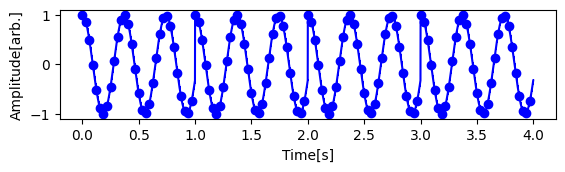

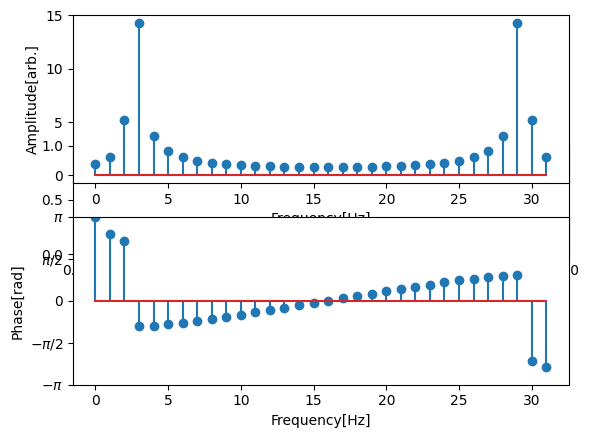

In [22]:
fs = 32                     # サンプリング周波数
f0 = 2.7                    # 基本周波数
t = np.arange(0, 1, 1/fs)   # 1[s]のサンプリング点
fn = A*np.cos(2*np.pi*f0*t) # サンプリング値の配列
sp = np.fft.fft(fn)

# アナログ波形(疑似)
fs_a = 1000
t_a = np.arange(0, 1, 1/fs_a)
fn_a = A*np.cos(2*np.pi*f0*t_a)

# 無理矢理4周期分繰り返す
for i in range(1, 3):
    t = np.append(t, t+float(i))
    fn = np.append(fn, fn)
    t_a = np.append(t_a, t_a+float(i))
    fn_a = np.append(fn_a, fn_a)

plt.subplot(3,1,1)
plot_wave(t_a, fn_a, hold=True)
plot_wave(t, fn, marker='o')

plt.subplot(3,1,2)
plot_FFT_spectrum(sp, fs)

これも不連続点が確認できる。

次に、3.1[Hz]で試してみる。

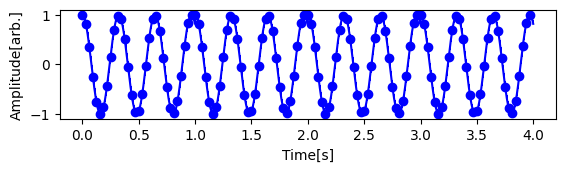

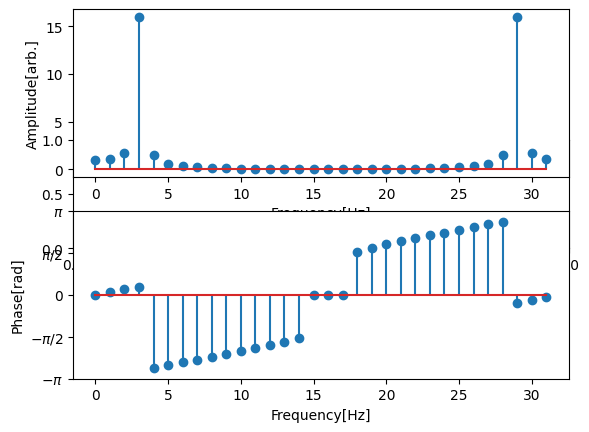

In [23]:
fs = 32                     # サンプリング周波数
f0 = 3.1                    # 基本周波数
t = np.arange(0, 1, 1/fs)   # 1[s]のサンプリング点
fn = A*np.cos(2*np.pi*f0*t) # サンプリング値の配列
sp = np.fft.fft(fn)

# アナログ波形(疑似)
fs_a = 1000
t_a = np.arange(0, 1, 1/fs_a)
fn_a = A*np.cos(2*np.pi*f0*t_a)

# 無理矢理4周期分繰り返す
for i in range(1, 3):
    t = np.append(t, t+float(i))
    fn = np.append(fn, fn)
    t_a = np.append(t_a, t_a+float(i))
    fn_a = np.append(fn_a, fn_a)

plt.subplot(3,1,1)
plot_wave(t_a, fn_a, hold=True)
plot_wave(t, fn, marker='o')

plt.subplot(3,1,2)
plot_FFT_spectrum(sp, fs)

やはり、小数点1位の値が0に近くなればなるほど、不連続点がなめらかになっていく。

無理矢理繰り返した場合に、波形の不連続が大きいと、振幅スペクトルの正しい周波数とは異なる周波数成分がプロットされていた。この不連続を小さくできるよう、**窓関数**を用いて波形を切り出してみる。

ハニング窓を試してみる。まず、ハニング窓の波形とスペクトルを確認する。ハニング窓は、次のように定義される。

$ w(n) = 0.5 - 0.5\cos \frac{2\pi(n + 0.5)}{N} $

In [24]:
def hanning_window(N):
    """
    ハニング窓
    N: 窓長
    """
    n = np.arange(0, N)
    window = (0.5-0.5*np.cos(2*np.pi*(n+0.5)/(N)))
    return window

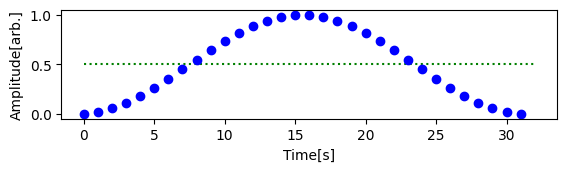

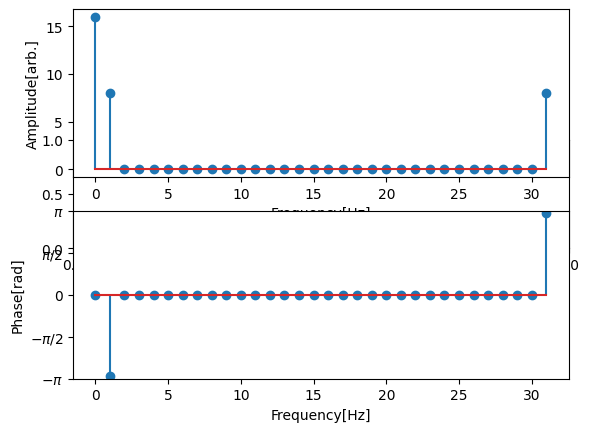

In [25]:
fs = N = 32                 # サンプリング周波数と1周期分のサンプリング点
n = np.arange(0, N)         # １周期分のサンプリング点の配列
window = hanning_window(N)  # ハニング窓
fft_result = np.fft.fft(window)

plt.subplot(3,1,1)
plt.hlines(0.5, 0, 32, color='g', linestyles='dotted')
plot_wave(n, window, marker='o')
plt.subplot(3,1,2)
plot_FFT_spectrum(fft_result, fs, level=False)

波形は、全体として正の値をとるため、直流成分がある。交流成分としては、N点で1周期となる-cos波なので、位相は $-\pi$。ただし、 $2\pi$ の不定性があるため、$-\pi$ と $\pi$ は同じである。

実際に、2.5[Hz]の波形にハニング窓を掛けてスペクトルを見てみる。

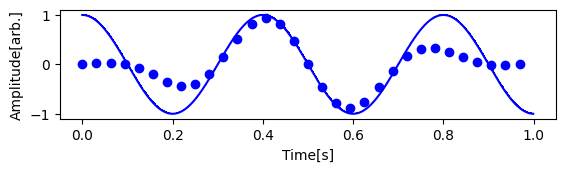

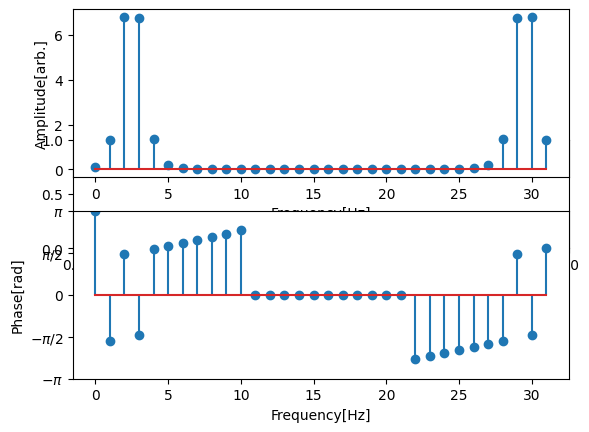

In [26]:
fs = 32                         # サンプリング周波数
f0 = 2.5                        # 基本周波数
A = 1.                          # 振幅
t = np.arange(0, 1, 1/fs)       # サンプリング点数(1[s]間)
wn = hanning_window(N)          # ハニング窓
fn = A*wn*np.cos(2*np.pi*f0*t)  # サンプリング値
sp = np.fft.fft(fn)

plt.subplot(3,1,1)
# アナログ波形(疑似)
fs_a = 1000
t_a = np.arange(0, 1, 1/fs_a)
fn_a = A*np.cos(2*np.pi*f0*t_a)
plot_wave(t_a, fn_a, hold=True)
# ディジタル波形
plot_wave(t, fn, marker='o')

plt.subplot(3,1,2)
plot_FFT_spectrum(sp, fs, level=False)

綺麗にサンプリングできてはいないが、窓関数を掛ける前に比べて不連続点が小さくなっているのがわかる。振幅スペクトルでは、2[Hz]と3[Hz]成分が大きくなっており、2.5[Hz]周辺を上手く表現できている。

サンプリング周波数が44.1[kHz]では、1[s]間に音を44100点をサンプリングする。このような継続時間が長い音を対象とするとき、その区間で音が定常であれば、全体をFFTし、スペクトルを調べることに意味がある。しかし、刻一刻と変化する音を考える場合には、1024点(=23.2[ms])など、さらに短い時間区間ごとで求める必要がある。このような処理を、STFT(Short-Time Fourier Transform : 短時間フーリエ変換)という。

読み込んだ音声データのハニング窓を掛ける前の波形を、128点でSTFTして、スペクトルをプロットしてみる。

Sampling frequency :  16000 [Hz]


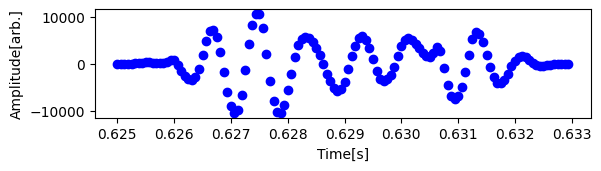

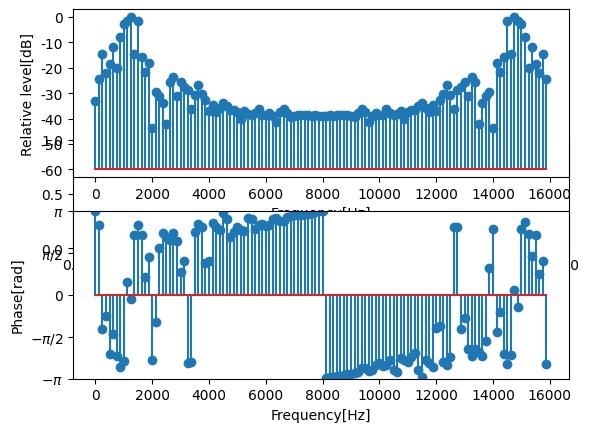

In [27]:
fs, wave_data = scipy.io.wavfile.read ('sample/sample_1.wav')
print('Sampling frequency : ', fs, '[Hz]')
ts = 1/fs                                       # サンプリング周期
sampling_time = np.arange(len(wave_data))*ts    # サンプリング期間
sampling_point = 128                            # プロットするサンプリング点
start = 10000                                   # プロットする開始サンプリング点
wn = hanning_window(sampling_point)             # ハニング窓
plt.subplot(3,1,1)
plot_wave(
    sampling_time[start:start+sampling_point],
    wn*wave_data[start:start+sampling_point],
    marker='o')
fft_result = np.fft.fft( wave_data[start : start + sampling_point] )
plt.subplot(3,1,2)
plot_FFT_spectrum(fft_result, fs, level=True)

窓関数を掛けてプロットする。

Sampling frequency :  16000 [Hz]


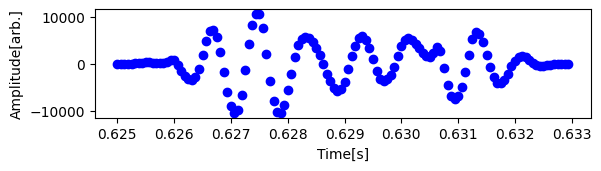

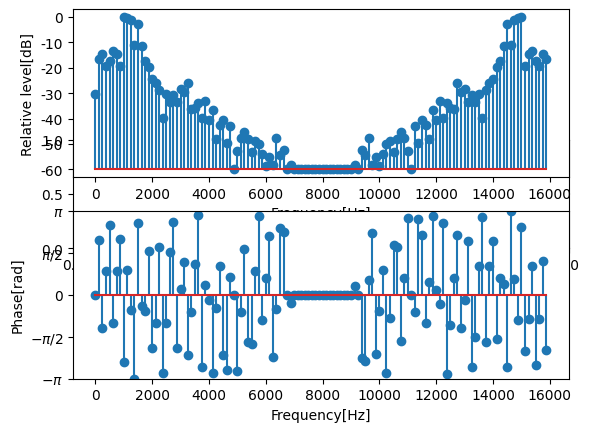

In [28]:
fs, wave_data = scipy.io.wavfile.read ('sample/sample_1.wav')
print('Sampling frequency : ', fs, '[Hz]')
ts = 1/fs                                       # サンプリング周期
sampling_time = np.arange(len(wave_data))*ts    # サンプリング期間
sampling_point = 128                            # プロットするサンプリング点
start = 10000                                   # プロットする開始サンプリング点
wn = hanning_window(sampling_point)             # ハニング窓
plt.subplot(3,1,1)
plot_wave(
    sampling_time[start:start+sampling_point],
    wn*wave_data[start:start+sampling_point],
    marker='o')
fft_result = np.fft.fft(wn*wave_data[start:start+sampling_point])
plt.subplot(3,1,2)
plot_FFT_spectrum(fft_result, fs, level=True)

ハニング窓を掛ける前と比べると、振幅スペクトルでは、少なくともナイキスト周波数(8000[Hz])周辺の暴れが小さくなっていることがわかる。また、フォルマントも見やすくなっている。

このように、STFTをある1区間だけ行い、その区間のスペクトルを観測することは意味がある。しかし、全体としてどのような音なのかを見るために、時間窓を推移させながら何度も繰り返したら、覚えきれない。そこで、全体をSTFTの集合体として見る。これは、スペクトログラムで見ることができる。

まず、スペクトログラムを見るために、下記サイトを参考に、白色雑音を頂上したFMの音を生成してみる。

https://docs.scipy.org/doc/scipy/reference/generated/scipy.signal.spectrogram.html

In [29]:
fs = 10e3                               # サンプリング周波数(10,000[Hz])
fn = fs/2                               # ナイキスト周波数(5,000[Hz])
N = 1e5                                 # サンプリング期間の点数(100,000点)
amp = 2*np.sqrt(2)                      # 振幅
noise_power = 0.01*fn                   # 白色雑音の大きさ
sampling_time = np.arange(N)/float(fs)  # サンプリング期間(N点)
mod = 500*np.cos(2*np.pi*0.25*sampling_time)
carrier = amp*np.sin(2*np.pi*1e3*sampling_time+mod)
noise = np.random.normal(
    scale=np.sqrt(noise_power),
    size=sampling_time.shape
    )
noise *= np.exp(-sampling_time/5)
x = carrier+noise
audio = Audio(x, rate=fs)
audio

次に、スペクトログラムをプロットしてみる。

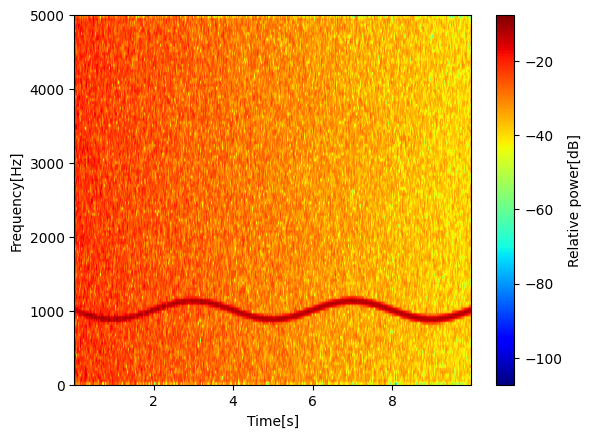

In [30]:
plt.specgram(x, NFFT=256, Fs=fs, cmap='jet')
plt.ylabel('Frequency[Hz]')
plt.xlabel('Time[s]')
plt.colorbar(orientation="vertical", label="Relative power[dB]")
plt.show()

見ての通り、スペクトログラムは横軸は、時間[s]、縦軸は、周波数[Hz]、成分の振幅の大きさはが明度で表現される。今回の場合だと、信号音の周波数が1[kHz]付近で変動し、開始付近で見られる白色雑音が弱くなっていく様子がわかる。先ほどの、音をもう一度再生してみると、確かに最初のほうが雑音が大きく、徐々に雑音が小さくなっていっており、スペクトログラムと一致している。

※振幅スペクトルは、偶関数なので、正の周波数成分のみが表示される。

次に、"あいうえお"と言う音声の録音して、そのスペクトログラムを見てみる。

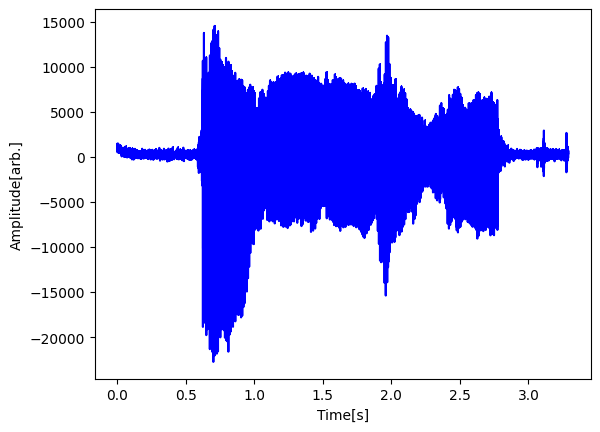

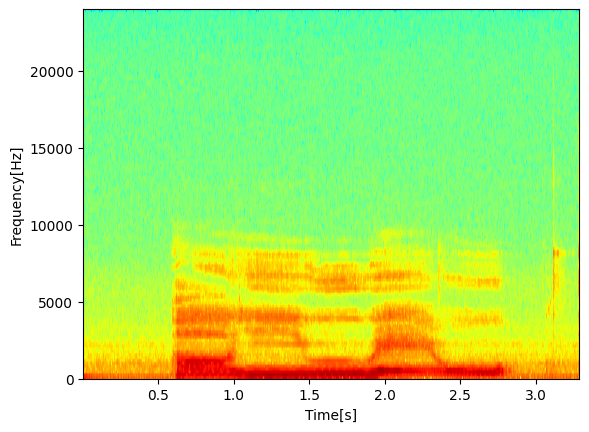

In [31]:
file_path = 'sample/sample_2.wav'
fs, wave_data = scipy.io.wavfile.read(file_path)
ts = 1/fs                                       # サンプリング周期
sampling_time = np.arange(len(wave_data))*ts    # サンプリング期間
plot_wave(sampling_time, wave_data)

# スペクトログラム
plt.specgram(wave_data, NFFT=256, Fs=fs, cmap='jet')
plt.ylabel('Frequency[Hz]')
plt.xlabel('Time[s]')
plt.show()

audio = Audio(wave_data, rate = fs)
audio

スペクトログラムには、いわゆる声紋が描かれている。母音の変化によるフォルマントの変動がわかる。

次に、"あいうえお"を区切って発話したものを録音して、そのスペクトログラムを見てみる。

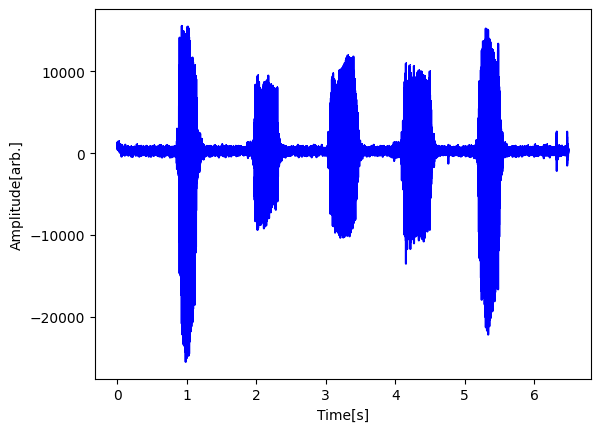

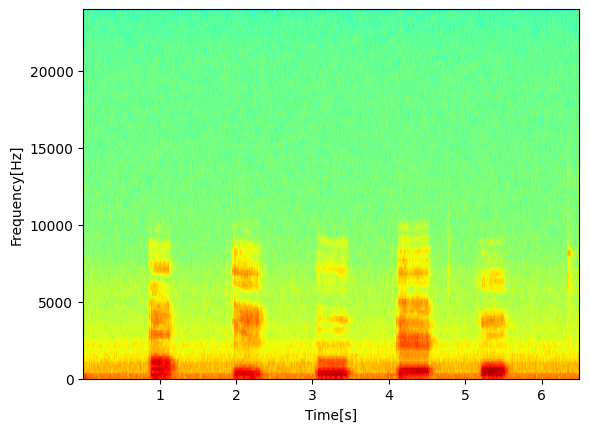

In [32]:
file_path = 'sample/sample_3.wav'
fs, wave_data = scipy.io.wavfile.read(file_path)
ts = 1/fs                                       # サンプリング周期
sampling_time = np.arange(len(wave_data))*ts    # サンプリング期間
plot_wave(sampling_time, wave_data)

# スペクトログラム
plt.specgram(wave_data, NFFT=256, Fs=fs, cmap='jet')
plt.ylabel('Frequency[Hz]')
plt.xlabel('Time[s]')
plt.show()

audio = Audio(wave_data, rate = fs)
audio

先ほどに比べて滑らかさがない。区切られて発話されているので、フォルマントの違いがわかりやすい。

## 窓関数による波形とスペクトルの変化

長い音から窓関数で切り出し、時間窓を推移させて同じ処理を行い、それをつなぎ合わせて、元の波形に戻すことを考えてみる。この処理は、長さ $N_A$ の音 $A$ に長さ $N_B$ の音 $B$ を一部重畳させ、加算する**オーバーラップアド(Over-Lap Add : 重畳加算)**を使う。

オーバーラップアド(Over-Lap Add : 重畳加算)の関数を定義しておく。ただし、音 $A$ の最後に音 $B$ の半分の長さだけを重ねる。

In [33]:
def overlap_add(sound_A, sound_B, overlap=None):
    """
    2音重畳加算
    ''' Parameter '''
    sound_A : 元の音
    sound_B : 重畳する音
    overlap : 重畳させる点数
    """
    if (overlap == None):
        overlap = int(len(sound_B)/2)   # 半分の長さを重畳
    elif (overlap == 0):
        return(np.r_[sound_A, sound_B]) # 音Aと音Bを連結

    # 重畳する長さがない場合
    if (len(sound_A) < overlap):
        # 音Bを崩さないように音Aの先頭に0系列を埋め込み重畳
        sound_A = np.r_[np.zeros(overlap-len(sound_A)), sound_A]

    print('Overlap :', overlap)
    sound_A = np.r_[sound_A[0:-overlap], sound_A[-overlap:] + sound_B[0:overlap]]
    sound_A = np.r_[sound_A, sound_B[overlap:]]
    return(sound_A)

まず、32点のハニング窓を生成し、それらをオーバーラップアドしてみる。

Overlap : 16


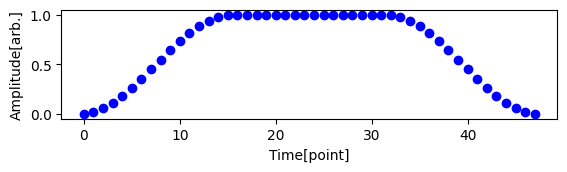

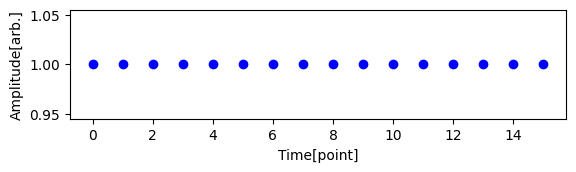

Overlap : 16


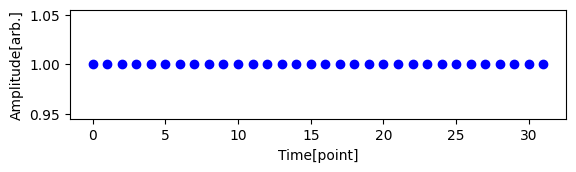

In [34]:
N = 32                  # 窓の長さ
wn = hanning_window(N)  # ハニング窓
shift = int(N/2)        # 窓の長さの半分シフト

# ハニング窓2つをオーバーラップアド
sum = overlap_add(wn, wn)
plt.subplot(3,1,1)
plot_wave([], sum, marker='o')

# ハニング窓2つをオーバーラップアドし、オーバーラップしている部分だけプロット
plt.subplot(3,1,2)
plot_wave([], sum[shift:-shift], marker='o')

# ハニング窓3つをオーバーラップアドし、オーバーラップしている部分だけプロット
sum = overlap_add(sum, wn)
plt.subplot(3,1,3)
plot_wave([], sum[shift:-shift], marker='o')

オーバーラップしている部分は、1の値であることがわかる。つまり、一旦は窓関数で切り出すことで別々の波形となるが、オーバーラップして重ねれば、元の波形に戻る。

同じことを numpyのハニング窓の関数で行ってみる。

Overlap : 16


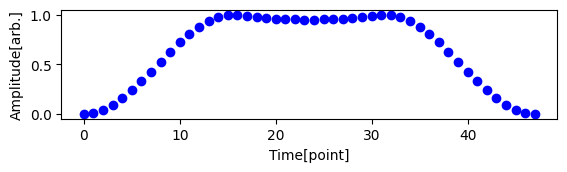

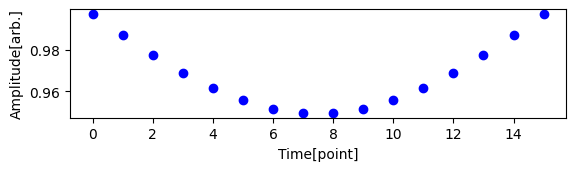

Overlap : 16


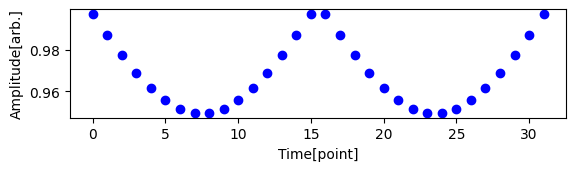

In [35]:
N = 32              # 長さ32 点の窓
wn = np.hanning(N)  # ハニング窓
shift = int(N/2)    # 窓の長さの半分シフト

# ハニング窓2つをオーバーラップアド
sum = overlap_add(wn, wn)
plt.subplot(3,1,1)
plot_wave([], sum, marker='o')

# ハニング窓2つをオーバーラップアドし、オーバーラップしている部分だけプロット
plt.subplot(3,1,2)
plot_wave([], sum[shift:-shift], marker='o')

# ハニング窓3つをオーバーラップアドし、オーバーラップしている部分だけプロット
sum = overlap_add(sum, wn)
plt.subplot(3,1,3)
plot_wave([], sum[shift:-shift], marker='o')

自作関数のハニング窓とは違う結果が得られた。推移させた窓で切り出して、つなげて戻しても、1に戻らない。これは、numpyでは、ハニング窓が下記のような式で定義されているからである。

$ w(n) = 0.5 -0.5 \cos \frac{2\pi n}{N - 1} $

つまり、左端の $n = 0$ から始まり、右端の $ n = N - 1 $ で終わる($ \cos 2\pi = 0$ であるから)。従って、FFTするための前処理での用途であれば、問題ないが、長い信号から切り出して、後からつなげるような処理の場合は、どの関数を使うか注意する必要がある。

自作で定義したハニング窓で、$N/2$だけ推移させた窓同士の足し算は次のようになる。

三角関数の積和の公式を使う。

$ \cos\alpha\cos\beta = \frac{1}{2}\{ \cos(\alpha + \beta) + \cos(\alpha - \beta) \}$

$
w(n) + w\left(n+\frac{N}{2}\right) = 0.5 - 0.5 \cos \frac{2 \pi (n+0.5)}{N} + 0.5 - 0.5 \cos \frac{2 \pi \left(n+N/2+0.5\right)}{N} \\
 =  1 - \left\{ \cos \frac{2 \pi (n+0.5)}{N}  + \cos \left( \frac{2 \pi (n+0.5)}{N} + \frac{2 \pi \cdot N/2}{N}\right)  \right\} \\
 =  1 - \left\{ \cos \frac{2 \pi (n+0.5)}{N}  + \cos \left( \frac{2 \pi (n+0.5)}{N} + \pi \right)  \right\} \\
 =  1 - \left\{ \cos \frac{2 \pi (n+0.5)}{N}  - \cos \frac{2 \pi (n+0.5)}{N}  \right\} \\
 =  1
$

numpyで定義されているハニング窓で、$N/2$だけ推移させた窓同士の足し算は次のようになる。

$
w(n) + w\left(n+\frac{N}{2}\right)  =  0.5 - 0.5 \cos \frac{2 \pi n}{N-1} + 0.5 - 0.5 \cos \frac{2 \pi \left(n+N/2\right)}{N-1} \\
 =  1 - \left\{ \cos \frac{2 \pi n}{N-1}  + \cos \left( \frac{2 \pi (n+ N/2)}{N-1} \right) \right\} \\
 =  1 - \left\{ \cos \frac{2 \pi n}{N-1}  - \cos \left( \frac{2 \pi (n+ 1/2)}{N-1} \right) \right\} \\
$


次に、データ数を増やし、窓を掛けてスペクトルすると、どう変化するにかを見てみる。

実数の波形 $f(n)$ は、負の周波数領域であるスペクトルの右半分は見る必要がない(振幅は偶関数、位相は奇関数であるため)。

In [36]:
_called_first = True # subplotを2回呼ばないようにする

def plot_FFT_spectrum_ver2(sp, fs=48000, level=False, plot_range=60, real_wave=False, phase_spectrum=True, stem=True, color='b', hold=False):
    """
    スペクトルプロット関数
    sp              : スペクトル結果
    fs              : サンプリング周波数[Hz]
    level           : True -> 相対レベル表示(縦軸)
    plot_range      : 縦軸範囲
    real_wave       : 実数波形
    phase_spectrum  : False -> 振幅スペクトルのみ
    stem            : True -> ○付き棒グラフ
    color           : グラフカラー
    hold            : True -> データ保持。
    """
    global _called_first, _ax1_for_FFTspectrum

    amp = np.abs(sp)    # 振幅
    ph = np.angle(sp)   # 位相

    # 振幅がプロット範囲より小さい場合は位相を0へ
    threshold = 10**(-plot_range / 20)*max(amp)
    ph[ amp < threshold ] = 0

    if (fs == None):
        # 横軸を正規化角周波数へ
        if (real_wave == False):
            omega_max = 2*np.pi         # 正規化角周波数は2πまでプロット
            f_number = len(amp)         # 周波数ビンの数
        else:
            omega_max = np.pi           # 正規化角周波数はπまでプロット
            f_number = int(len(amp)/2)  # ナイキスト周波数までの周波数ビンの数
        frequency = np.linspace(0, omega_max, f_number, endpoint=False)
        xtitle = 'Normarized angular frequency[rad]'
    else:
        if (real_wave == False):
            f_max = fs                  # サンプリング周波数までプロット
            f_number = len(amp)         # 周波数ビンの数
        else:
            f_max = fs/2                # ナイキスト周波数までプロット
            f_number = int(len(amp)/2)  # ナイキスト周波数までの周波数ビンの数
        frequency = np.linspace(0, f_max, f_number, endpoint=False) # 基本周波数とその整数倍の周波数の配列
        xtitle = 'Frequency[Hz]'

    ''' 振幅スペクトル '''
    ytitle = 'Amplitude[arb.]'

    if (level == True):
        # 振幅が0の場合にlogの計算エラーが出ないよう、計算機イプシロン(1より大きい最小の数)を加算
        amp = amp + np.finfo(float).eps
        amp = 20*np.log10(np.abs(amp[0:f_number]/np.max(amp[0:f_number])))  # 最大振幅を0[dB]とした相対レベルを計算
        amp = amp + plot_range                                              # stemの描画のため描画範囲を加算
        amp[amp < 0] = 0                                                    # plot_range未満は0
        ytitle = 'Relative level[dB]'

    # 重ねてプロット
    if (_called_first == True):
        _ax1_for_FFTspectrum = plt.subplot(2, 1, 1)
        _called_first = False

    if (stem == True):
        _ax1_for_FFTspectrum.stem(frequency[0:f_number], amp[0: f_number])
    else:
        _ax1_for_FFTspectrum.plot(frequency[0:f_number], amp[0: f_number], color=color)
    if (xtitle == 'Normarized angular frequency (rad)'):
        if (real_wave == False):
            plt.xticks(
                [0, np.pi/2, np.pi, 3*np.pi/2, 2*np.pi],
                ["$0$", "$0.5 \pi$" ,"$\pi$", "$1.5 \pi$", "$2 \pi$"])
        else:
            plt.xticks(
                [0, np.pi/4, np.pi/2, 3*np.pi/4, np.pi],
                ["$0$", "$0.25 \pi$" ,"$0.5 \pi$", "$0.75 \pi$", "$\pi$"])

    plt.xlabel(xtitle)
    plt.ylabel(ytitle)

    if (level == True):
        plt.yticks(
            [i for i in range(0, int(plot_range) + 1, 10)],
            [str(i) for i in range(-int(plot_range), 0+1, 10)])

    if (phase_spectrum == False):
        if (hold == False):
            plt.show()
            _called_first = True
        return

    ''' 位相スペクトル '''
    ytitle = 'Phase[rad]'
    plt.subplot(2, 1, 2)
    if (stem == True):
        plt.stem(frequency[0:f_number], ph[0: f_number])
    else:
        plt.plot(frequency[0:f_number], ph[0: f_number])

    if (xtitle == 'Normarized angular frequency (rad)'):
        if (real_wave == False):
            plt.xticks(
                [0, np.pi/2, np.pi, 3*np.pi/2, 2*np.pi],
                ["$0$", "$0.5 \pi$" ,"$\pi$", "$1.5 \pi$", "$2 \pi$"])
        else:
            plt.xticks(
                [0, np.pi/4, np.pi/2, 3*np.pi/4, np.pi],
                ["$0$", "$0.25 \pi$" ,"$0.5 \pi$", "$0.75 \pi$", "$\pi$"])

    plt.xlabel(xtitle)
    plt.ylabel(ytitle)
    plt.ylim(-np.pi, np.pi)
    plt.yticks(
        [-np.pi, -np.pi/2, 0, np.pi/2, np.pi],
        ["$-\pi$", "$-\pi/2$" ,"0", "$\pi/2$", "$\pi$"])

    if (hold == False):
        plt.show()
        _called_first = True

まず、周波数ビンに載らない周波数の正弦波の2成分を足し合わせた波形にハミング窓を掛けたスペクトルを見てみる。

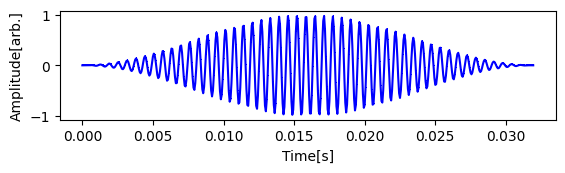

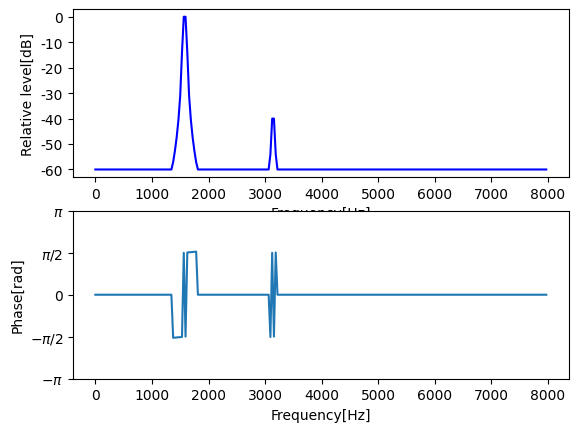

In [51]:
fs = 16000                      # サンプリング周波数
N = 512                         # FFTする点数
t = np.arange(0, N)*1/fs        # サンプリング期間
wn = hanning_window(N)          # ハニング窓

# 第1成分
f1 = 50.5 * fs/N                # 周波数ビンが50番と51番の中間の周波数
A1 = 1                          # 振幅
f1n = A1*np.cos(2*np.pi*f1*t)   # サンプリング値

# 第2成分
f2 = 100.5 * fs/N               # 周波数ビンが100番と101番の中間の周波数
A2 = 0.01                       # 振幅
f2n = A2*np.cos(2*np.pi*f2*t)   # サンプリング値

# ２成分を足し合わせてハニング窓を掛ける
f3n = wn*(f1n + f2n)
fft_result = np.fft.fft(f3n)

plt.subplot(3,1,1)
plot_wave(t, f3n)

# real_waveが"True"でスペクトルのプロットをナイキスト周波数までに制限
plot_FFT_spectrum_ver2(fft_result, fs, level=True, stem=False, real_wave=True)

振幅スペクトルを見てみると、1.5[kHz]周辺と3[kHz]周辺に2成分あることがわかる。

次に、ハミング窓を掛けずに見てみる。

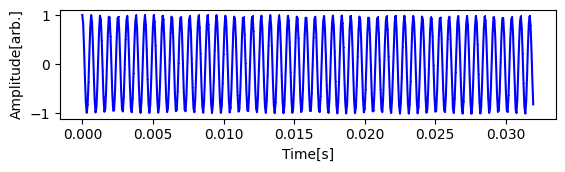

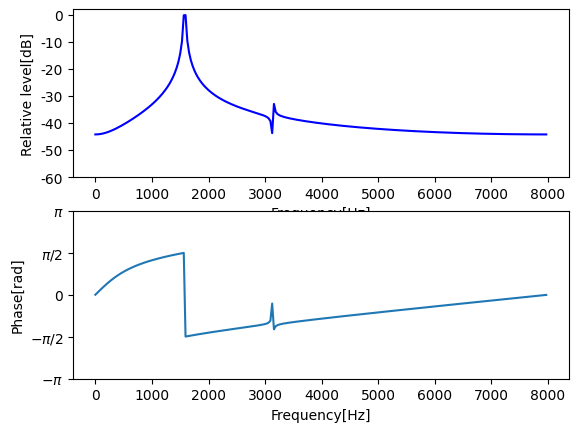

In [43]:
fs = 16000                      # サンプリング周波数
N = 512                         # FFTする点数
t = np.arange(0, N)*1/fs        # サンプリング期間
wn = hanning_window(N)          # ハニング窓

# 第1成分
f1 = 50.5 * fs/N                # 周波数ビンが50番と51番の中間の周波数
A1 = 1                          # 振幅
f1n = A1*np.cos(2*np.pi*f1*t)   # サンプリング値

# 第2成分
f2 = 100.5 * fs/N               # 周波数ビンが100番と101番の中間の周波数
A2 = 0.01                       # 振幅
f2n = A2*np.cos(2*np.pi*f2*t)   # サンプリング値

# ２成分の足し合わせて
f3n = f1n + f2n
fft_result = np.fft.fft(f3n)

plt.subplot(3,1,1)
plot_wave(t, f3n)

# real_waveが"True"でスペクトルのプロットをナイキスト周波数までに制限
plot_FFT_spectrum_ver2(fft_result, fs, level=True, stem=False, real_wave=True)

何となく、1.5[kHz]周辺と3[kHz]周辺に2成分あることがわかるが、ハミング窓を掛けたときと比べて、わかりにくい。

次に、f2の波形の係数を100.5から50.5に変更してみる。

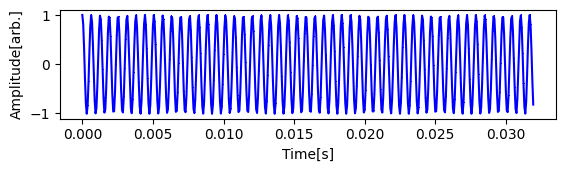

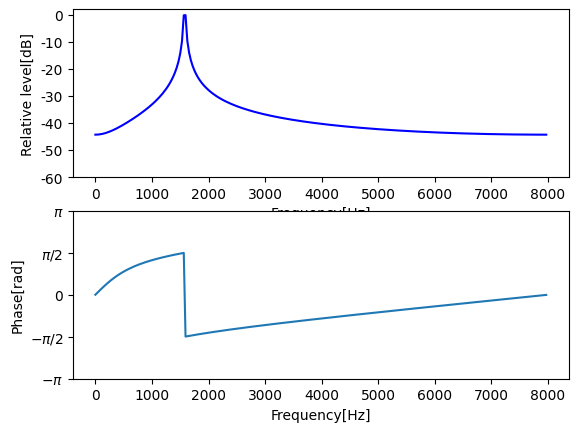

In [46]:
fs = 16000                      # サンプリング周波数
N = 512                         # FFTする点数
t = np.arange(0, N)*1/fs        # サンプリング期間
wn = hanning_window(N)          # ハニング窓

# 第1成分
f1 = 50.5 * fs/N                # 周波数ビンが50番と51番の中間の周波数
A1 = 1                          # 振幅
f1n = A1*np.cos(2*np.pi*f1*t)   # サンプリング値

# 第2成分
f2 = 50.5 * fs/N                # 周波数ビンが50番と51番の中間の周波数
A2 = 0.01                       # 振幅
f2n = A2*np.cos(2*np.pi*f2*t)   # サンプリング値

# ２成分の足し合わせて
f3n = f1n + f2n
fft_result = np.fft.fft(f3n)

plt.subplot(3,1,1)
plot_wave(t, f3n)

# real_waveが"True"でスペクトルのプロットをナイキスト周波数までに制限
plot_FFT_spectrum_ver2(fft_result, fs, level=True, stem=False, real_wave=True)

3[kHz]周辺の成分が完全に消えた。

ここで、またハミング窓を掛けてみる。

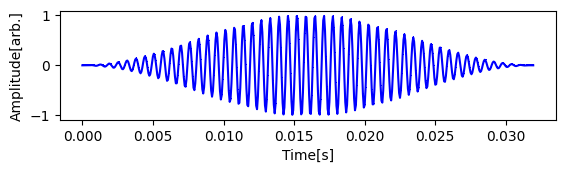

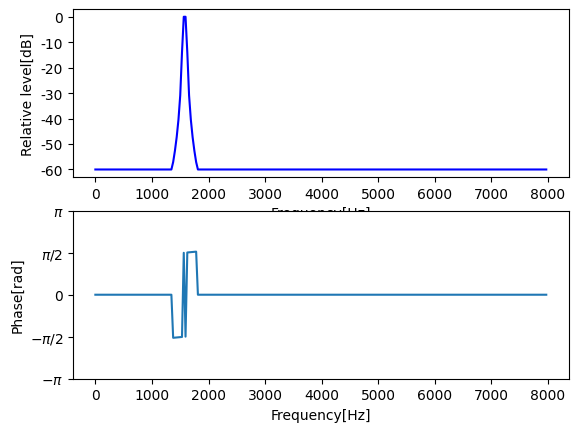

In [47]:
fs = 16000                      # サンプリング周波数
N = 512                         # FFTする点数
t = np.arange(0, N)*1/fs        # サンプリング期間
wn = hanning_window(N)          # ハニング窓

# 第1成分
f1 = 50.5 * fs/N                # 周波数ビンが50番と51番の中間の周波数
A1 = 1                          # 振幅
f1n = A1*np.cos(2*np.pi*f1*t)   # サンプリング値

# 第2成分
f2 = 50.5 * fs/N                # 周波数ビンが50番と51番の中間の周波数
A2 = 0.01                       # 振幅
f2n = A2*np.cos(2*np.pi*f2*t)   # サンプリング値

# ２成分の足し合わせて
f3n = wn*(f1n + f2n)
fft_result = np.fft.fft(f3n)

plt.subplot(3,1,1)
plot_wave(t, f3n)

# real_waveが"True"でスペクトルのプロットをナイキスト周波数までに制限
plot_FFT_spectrum_ver2(fft_result, fs, level=True, stem=False, real_wave=True)

窓を掛けることで振幅の広がりを抑えられることが確認できた。これにより、強い周波数成分の周辺にある弱い周波数成分を検出できるようになる。ただし、窓を掛けると、切り出した長さが周期の整数倍である音、つまり、周波数ビンに載る周波数については、本来の周波数成分のスペクトルが広がってしまう。それを確認するために、f1の係数を50に変更し、ハミング窓を掛けた場合とそうでない場合を比べてみる。

ハミング窓を掛けた場合

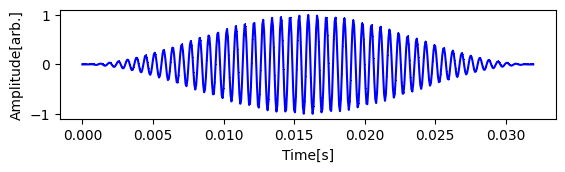

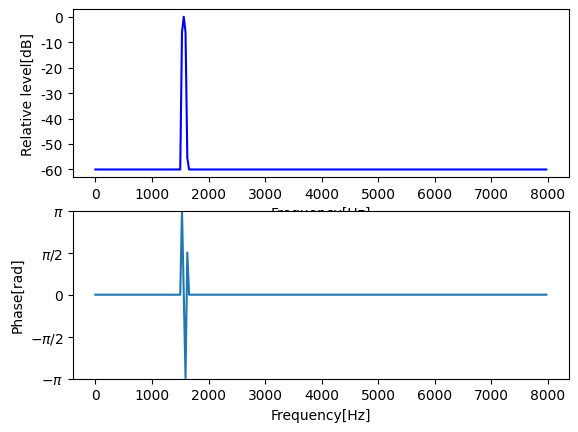

In [48]:
fs = 16000                      # サンプリング周波数
N = 512                         # FFTする点数
t = np.arange(0, N)*1/fs        # サンプリング期間
wn = hanning_window(N)          # ハニング窓

# 第1成分
f1 = 50.0 * fs/N                # 周波数ビンが50番と51番の中間の周波数
A1 = 1                          # 振幅
f1n = A1*np.cos(2*np.pi*f1*t)   # サンプリング値

# 第2成分
f2 = 50.5 * fs/N                # 周波数ビンが50番と51番の中間の周波数
A2 = 0.01                       # 振幅
f2n = A2*np.cos(2*np.pi*f2*t)   # サンプリング値

# ２成分の足し合わせて
f3n = wn*(f1n + f2n)
fft_result = np.fft.fft(f3n)

plt.subplot(3,1,1)
plot_wave(t, f3n)

# real_waveが"True"でスペクトルのプロットをナイキスト周波数までに制限
plot_FFT_spectrum_ver2(fft_result, fs, level=True, stem=False, real_wave=True)

ハミング窓を掛けない場合

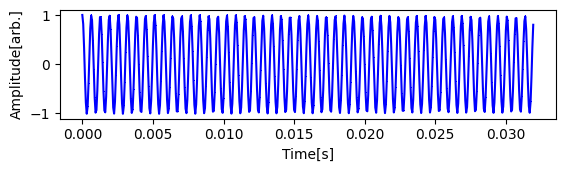

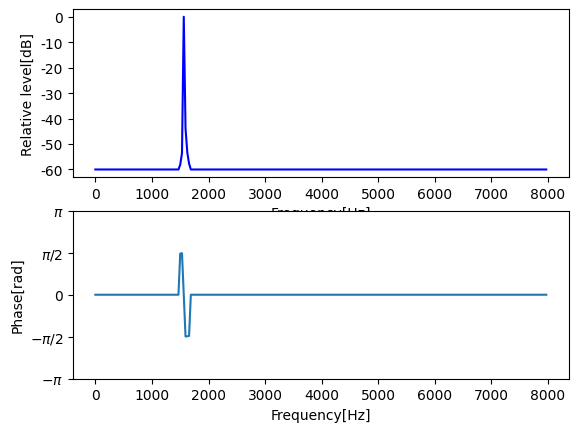

In [53]:
fs = 16000                      # サンプリング周波数
N = 512                         # FFTする点数
t = np.arange(0, N)*1/fs        # サンプリング期間
wn = hanning_window(N)          # ハニング窓

# 第1成分
f1 = 50.0 * fs/N                # 周波数ビンが50番の周波数
A1 = 1                          # 振幅
f1n = A1*np.cos(2*np.pi*f1*t)   # サンプリング値

# 第2成分
f2 = 50.5 * fs/N                # 周波数ビンが50番と51番の中間の周波数
A2 = 0.01                       # 振幅
f2n = A2*np.cos(2*np.pi*f2*t)   # サンプリング値

# ２成分の足し合わせて
f3n = f1n + f2n
fft_result = np.fft.fft(f3n)

plt.subplot(3,1,1)
plot_wave(t, f3n)

# real_waveが"True"でスペクトルのプロットをナイキスト周波数までに制限
plot_FFT_spectrum_ver2(fft_result, fs, level=True, stem=False, real_wave=True)

ハミング窓を掛けていないときの方が、ハミング窓を掛けているときに比べて、本来の周波数成分を捉えられている。このように、本来の周波数成分のスペクトルが広がることを、**周波数分解能が悪くなる**という。

## 位相スペクトル

音色に関しては、位相特性よりも振幅特性の方が大きな影響を及ぼす。また、振幅スペクトルのフォルマントが母音の知覚に大きな影響を及ぼしていることからも、振幅スペクトルの方が重要と言えば重要。とはいえ、位相スペクトルが重要な場合もある。

まず、**インパルス**または**単位パルス**について考えてみる。単位パルスは、最初の点だけ1で、その後は全て0となる。

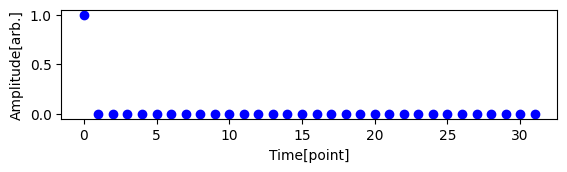

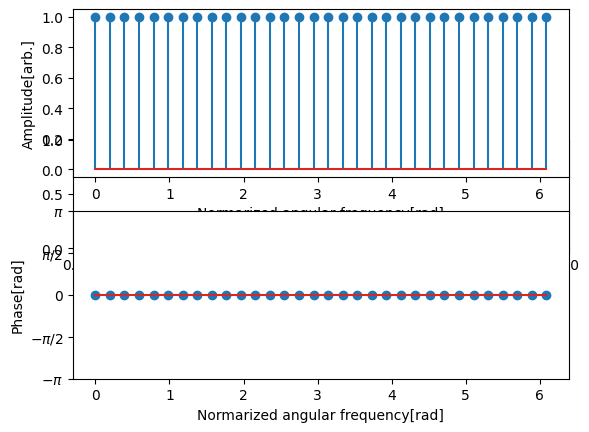

In [59]:
N =  32        # FFTする点数
fs = None      # サンプリング周波数
t = []
# 単位パルス
unit_pulse = np.append(
    np.array([1.0]),
    np.array([0.0 for i in range(N-1)]))
fft_result = np.fft.fft(unit_pulse)

plt.subplot(3,1,1)
plot_wave (t, unit_pulse, marker='o')
plt.subplot(3,1,2)
plot_FFT_spectrum_ver2(fft_result, fs=fs, real_wave=False)

振幅スペクトルを見てみると、すべての周波数成分の振幅が1で、位相についてはすべて0となっている。すべての周波数成分を振幅の等しいcos波を重ねてい行くと、時刻0ではすべての周波数成分が1を取るので、重ねた結果大きくなり、それ以外の時刻では、周波数成分ごとに異なる値を取るため、重ねた結果、相殺されて0になり、このような波形になる。

スペクトルの横軸が正規化角周波数では分かりづらい場合は、サンプリング周波数で見てみる。

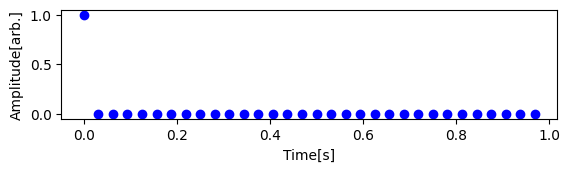

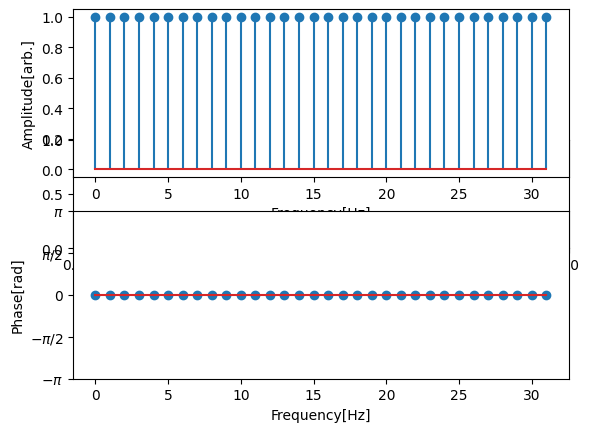

In [72]:
N =  32                 # FFTする点数
fs = 32                 # サンプリング周波数
t = np.arange(N)*1/fs   # N点のサンプリング期間

# 単位パルス
unit_pulse = np.append(
    np.array([1.0]),
    np.array([0.0 for i in range(N-1)]))
fft_result = np.fft.fft(unit_pulse)

plt.subplot(3,1,1)
plot_wave (t, unit_pulse, marker='o')
plt.subplot(3,1,2)
plot_FFT_spectrum_ver2(fft_result, fs=fs, real_wave=False)

次に、1点だけ遅延させて、スペクトルを見てみる。

In [73]:
def n_shift_wave(wave, n):
    """
    時間波形をn点だけ円状シフト
    """
    n_shift = (np.r_[wave[-n:], wave[:-n]])
    return n_shift

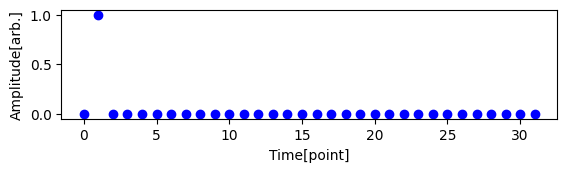

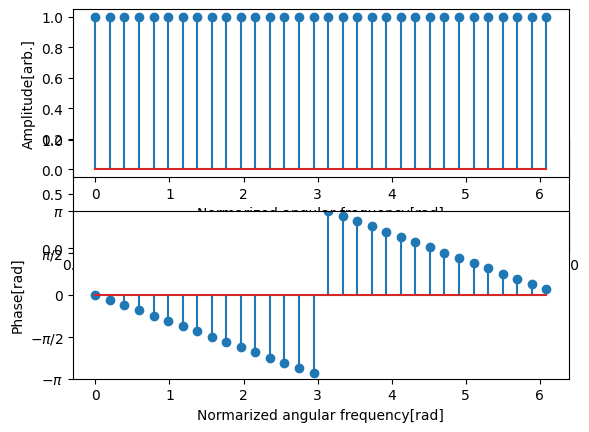

In [74]:
N =  32        # FFTする点数
fs = None      # サンプリング周波数
t = []
# 単位パルス
unit_pulse = np.append(
    np.array([1.0]),
    np.array([0.0 for i in range(N-1)]))
fft_result = np.fft.fft(unit_pulse)

n0 = 1                                          # 遅延させる点数
shifted_pulse = n_shift_wave(unit_pulse, n0)    # 円状シフト
fft_result = np.fft.fft(shifted_pulse)

plt.subplot(3,1,1)
plot_wave(t, shifted_pulse, marker='o')
plt.subplot(3,1,2)
# real_waveが"True"でスペクトルのプロットをナイキスト周波数までに制限
plot_FFT_spectrum_ver2(fft_result, fs=fs, real_wave=False)

次に、2点だけ遅延させてみる。

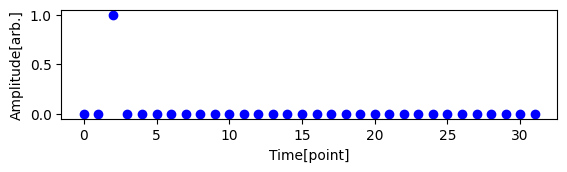

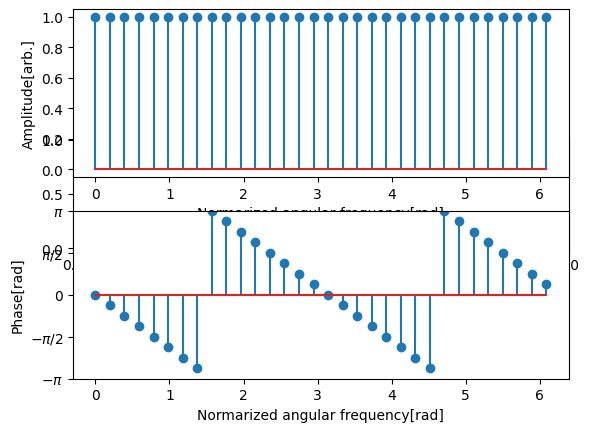

In [75]:
N =  32        # FFTする点数
fs = None      # サンプリング周波数
t = []
# 単位パルス
unit_pulse = np.append(
    np.array([1.0]),
    np.array([0.0 for i in range(N-1)]))
fft_result = np.fft.fft(unit_pulse)

n0 = 2                                          # 遅延させる点数
shifted_pulse = n_shift_wave(unit_pulse, n0)    # 円状シフト
fft_result = np.fft.fft(shifted_pulse)

plt.subplot(3,1,1)
plot_wave(t, shifted_pulse, marker='o')
plt.subplot(3,1,2)
# real_waveが"True"でスペクトルのプロットをナイキスト周波数までに制限
plot_FFT_spectrum_ver2(fft_result, fs=fs, real_wave=False)

次に、3点だけ遅延させてみる。

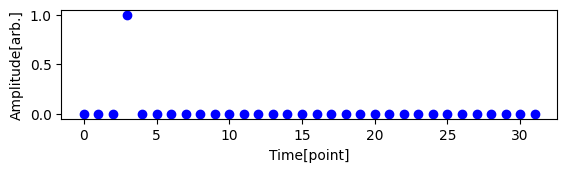

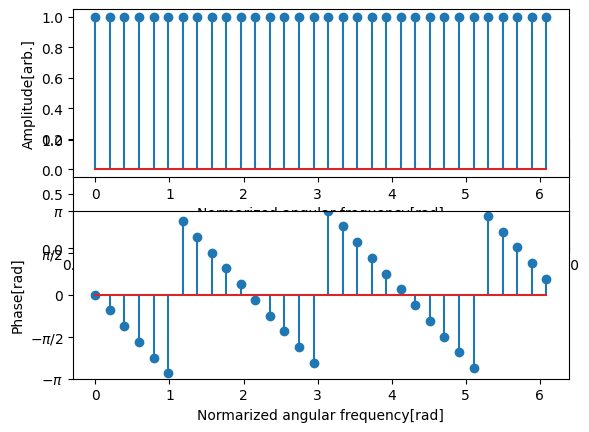

In [70]:
N =  32        # FFTする点数
fs = None      # サンプリング周波数
t = []
# 単位パルス
unit_pulse = np.append(
    np.array([1.0]),
    np.array([0.0 for i in range(N-1)]))
fft_result = np.fft.fft(unit_pulse)

n0 = 3                                          # 遅延させる点数
shifted_pulse = n_shift_wave(unit_pulse, n0)    # 円状シフト
fft_result = np.fft.fft(shifted_pulse)

plt.subplot(3,1,1)
plot_wave(t, shifted_pulse, marker='o')
plt.subplot(3,1,2)
# real_waveが"True"でスペクトルのプロットをナイキスト周波数までに制限
plot_FFT_spectrum_ver2(fft_result, fs=fs, real_wave=False)

振幅スペクトルは不変で、位相スペクトルは周波数に比例した変化を見てとれる。信号の時間軸上の推移は、振幅スペクトルを変化させずに、位相スペクトルに直線位相の変化、つまり、周波数に比例した位相回転を与える。このような、位相スペクトルを**直線位相**、または**線形位相**という。このような位相回転が起こるのは、例えば、1[Hz]の波を1[s]だけ遅延させるには、2πだけ位相を回せばよいのに対し、2[Hz]の波を1[s]遅延させるには、4π位相を回す必要があることと同じ理屈である。

次に、さらに遅延する点数を増やていき、32点まで遅延させてみる。

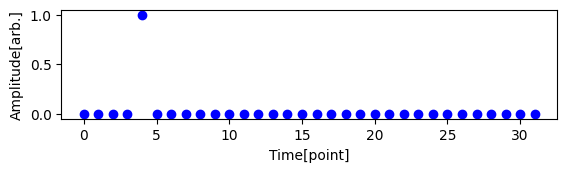

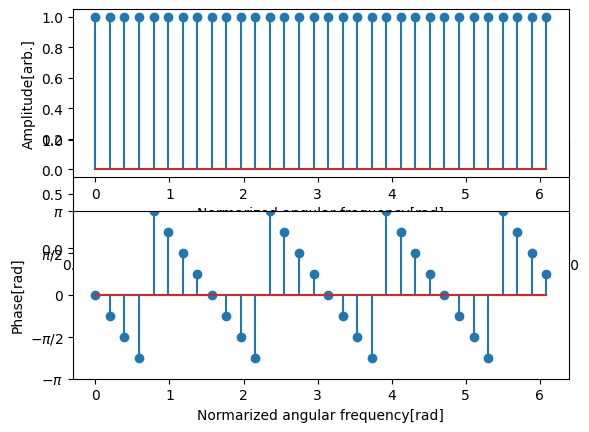

In [77]:
N =  32        # FFTする点数
fs = None      # サンプリング周波数
t = []
# 単位パルス
unit_pulse = np.append(
    np.array([1.0]),
    np.array([0.0 for i in range(N-1)]))
fft_result = np.fft.fft(unit_pulse)

n0 = 4                                          # 遅延させる点数
shifted_pulse = n_shift_wave(unit_pulse, n0)    # 円状シフト
fft_result = np.fft.fft(shifted_pulse)

plt.subplot(3,1,1)
plot_wave(t, shifted_pulse, marker='o')
plt.subplot(3,1,2)
# real_waveが"True"でスペクトルのプロットをナイキスト周波数までに制限
plot_FFT_spectrum_ver2(fft_result, fs=fs, real_wave=False)

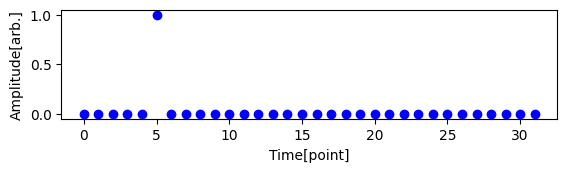

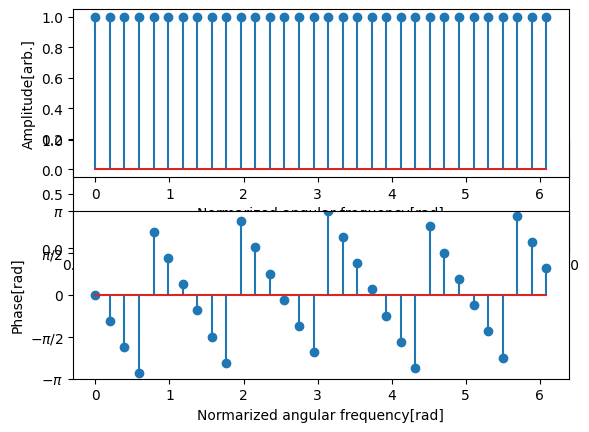

In [78]:
N =  32        # FFTする点数
fs = None      # サンプリング周波数
t = []
# 単位パルス
unit_pulse = np.append(
    np.array([1.0]),
    np.array([0.0 for i in range(N-1)]))
fft_result = np.fft.fft(unit_pulse)

n0 = 5                                          # 遅延させる点数
shifted_pulse = n_shift_wave(unit_pulse, n0)    # 円状シフト
fft_result = np.fft.fft(shifted_pulse)

plt.subplot(3,1,1)
plot_wave(t, shifted_pulse, marker='o')
plt.subplot(3,1,2)
# real_waveが"True"でスペクトルのプロットをナイキスト周波数までに制限
plot_FFT_spectrum_ver2(fft_result, fs=fs, real_wave=False)

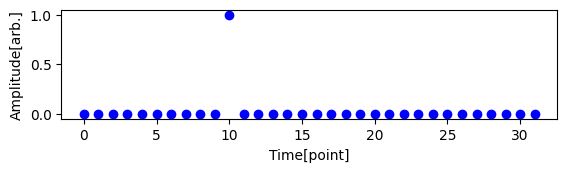

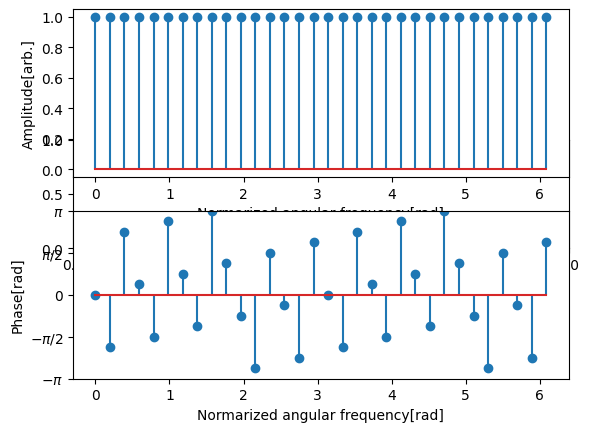

In [79]:
N =  32        # FFTする点数
fs = None      # サンプリング周波数
t = []
# 単位パルス
unit_pulse = np.append(
    np.array([1.0]),
    np.array([0.0 for i in range(N-1)]))
fft_result = np.fft.fft(unit_pulse)

n0 = 10                                         # 遅延させる点数
shifted_pulse = n_shift_wave(unit_pulse, n0)    # 円状シフト
fft_result = np.fft.fft(shifted_pulse)

plt.subplot(3,1,1)
plot_wave(t, shifted_pulse, marker='o')
plt.subplot(3,1,2)
# real_waveが"True"でスペクトルのプロットをナイキスト周波数までに制限
plot_FFT_spectrum_ver2(fft_result, fs=fs, real_wave=False)

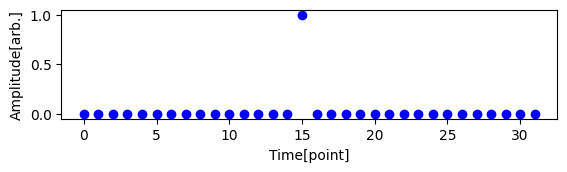

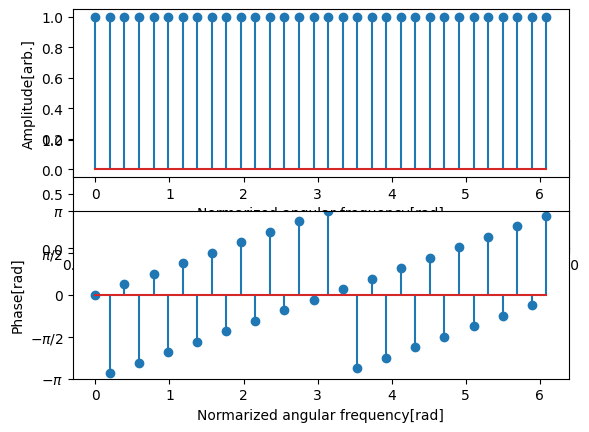

In [80]:
N =  32        # FFTする点数
fs = None      # サンプリング周波数
t = []
# 単位パルス
unit_pulse = np.append(
    np.array([1.0]),
    np.array([0.0 for i in range(N-1)]))
fft_result = np.fft.fft(unit_pulse)

n0 = 15                                         # 遅延させる点数
shifted_pulse = n_shift_wave(unit_pulse, n0)    # 円状シフト
fft_result = np.fft.fft(shifted_pulse)

plt.subplot(3,1,1)
plot_wave(t, shifted_pulse, marker='o')
plt.subplot(3,1,2)
# real_waveが"True"でスペクトルのプロットをナイキスト周波数までに制限
plot_FFT_spectrum_ver2(fft_result, fs=fs, real_wave=False)

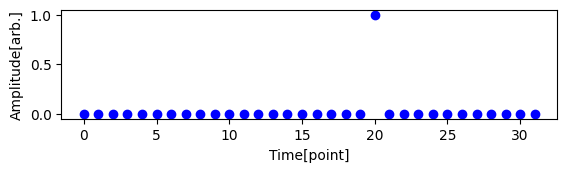

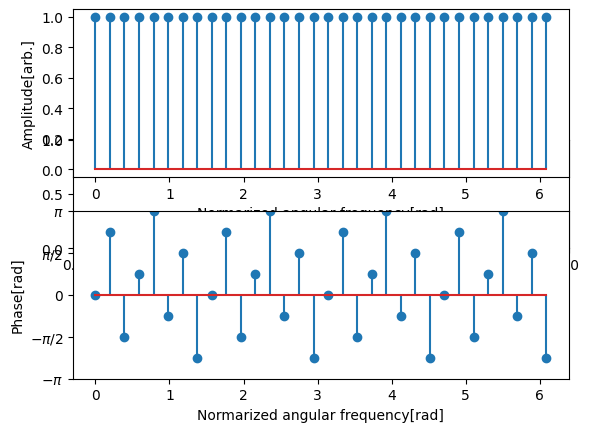

In [81]:
N =  32        # FFTする点数
fs = None      # サンプリング周波数
t = []
# 単位パルス
unit_pulse = np.append(
    np.array([1.0]),
    np.array([0.0 for i in range(N-1)]))
fft_result = np.fft.fft(unit_pulse)

n0 = 20                                         # 遅延させる点数
shifted_pulse = n_shift_wave(unit_pulse, n0)    # 円状シフト
fft_result = np.fft.fft(shifted_pulse)

plt.subplot(3,1,1)
plot_wave(t, shifted_pulse, marker='o')
plt.subplot(3,1,2)
# real_waveが"True"でスペクトルのプロットをナイキスト周波数までに制限
plot_FFT_spectrum_ver2(fft_result, fs=fs, real_wave=False)

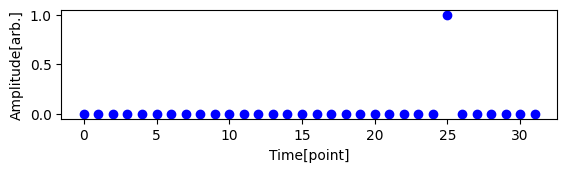

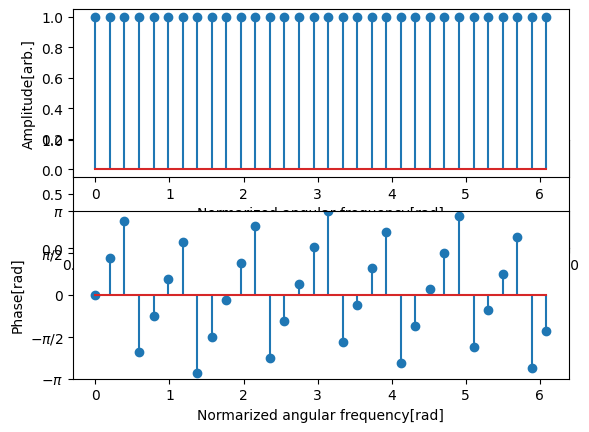

In [82]:
N =  32        # FFTする点数
fs = None      # サンプリング周波数
t = []
# 単位パルス
unit_pulse = np.append(
    np.array([1.0]),
    np.array([0.0 for i in range(N-1)]))
fft_result = np.fft.fft(unit_pulse)

n0 = 25                                         # 遅延させる点数
shifted_pulse = n_shift_wave(unit_pulse, n0)    # 円状シフト
fft_result = np.fft.fft(shifted_pulse)

plt.subplot(3,1,1)
plot_wave(t, shifted_pulse, marker='o')
plt.subplot(3,1,2)
# real_waveが"True"でスペクトルのプロットをナイキスト周波数までに制限
plot_FFT_spectrum_ver2(fft_result, fs=fs, real_wave=False)

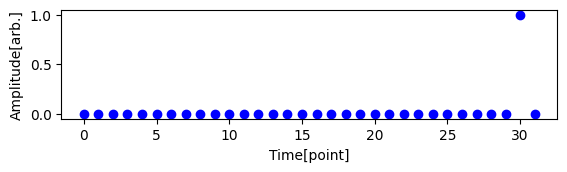

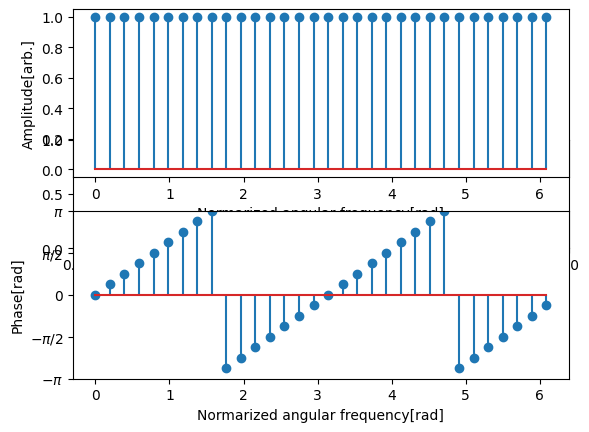

In [83]:
N =  32        # FFTする点数
fs = None      # サンプリング周波数
t = []
# 単位パルス
unit_pulse = np.append(
    np.array([1.0]),
    np.array([0.0 for i in range(N-1)]))
fft_result = np.fft.fft(unit_pulse)

n0 = 30                                         # 遅延させる点数
shifted_pulse = n_shift_wave(unit_pulse, n0)    # 円状シフト
fft_result = np.fft.fft(shifted_pulse)

plt.subplot(3,1,1)
plot_wave(t, shifted_pulse, marker='o')
plt.subplot(3,1,2)
# real_waveが"True"でスペクトルのプロットをナイキスト周波数までに制限
plot_FFT_spectrum_ver2(fft_result, fs=fs, real_wave=False)

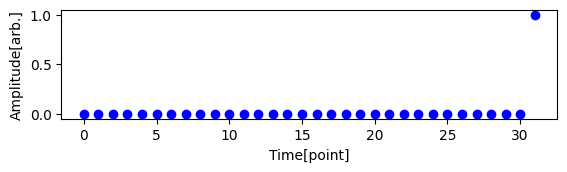

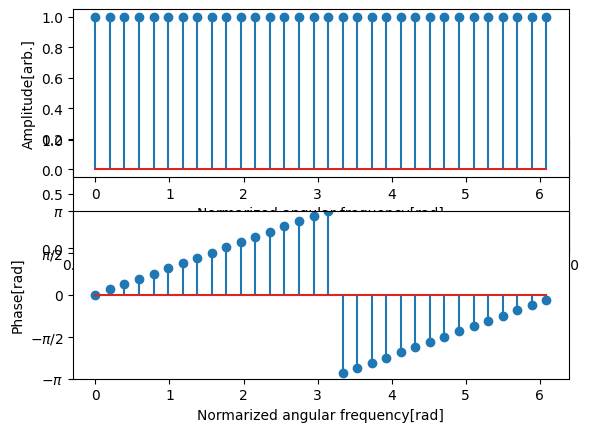

In [85]:
N =  32        # FFTする点数
fs = None      # サンプリング周波数
t = []
# 単位パルス
unit_pulse = np.append(
    np.array([1.0]),
    np.array([0.0 for i in range(N-1)]))
fft_result = np.fft.fft(unit_pulse)

n0 = 31                                         # 遅延させる点数
shifted_pulse = n_shift_wave(unit_pulse, n0)    # 円状シフト
fft_result = np.fft.fft(shifted_pulse)

plt.subplot(3,1,1)
plot_wave(t, shifted_pulse, marker='o')
plt.subplot(3,1,2)
# real_waveが"True"でスペクトルのプロットをナイキスト周波数までに制限
plot_FFT_spectrum_ver2(fft_result, fs=fs, real_wave=False)

遅延量を大きくしていくと、位相スペクトルの傾きが大きいことがわかる。

遅延量 $n_0$ が $n_0 > 1$ では、複素数の偏角の性質より、$-\pi$ と $-\pi$ は同じ偏角であり、それゆえ、$-\pi - \alpha$ は、 $\pi - \alpha$ と同じ偏角である。また、偏角に $2\pi$ の整数倍を加えても、同じ偏角となる。従って、スペクトルが $\pm\pi$ で不連続になっているように見えるが、 $2\pi$ の整数倍を加えると直線上に載るため、直線位相という性質は保たれる。つまり、スペクトルに直線位相の変化を与えると、信号を時間軸上で推移させることができる。

次に、 遅延させるポイントを0.5点にしてみる。

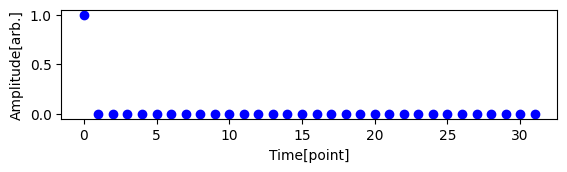

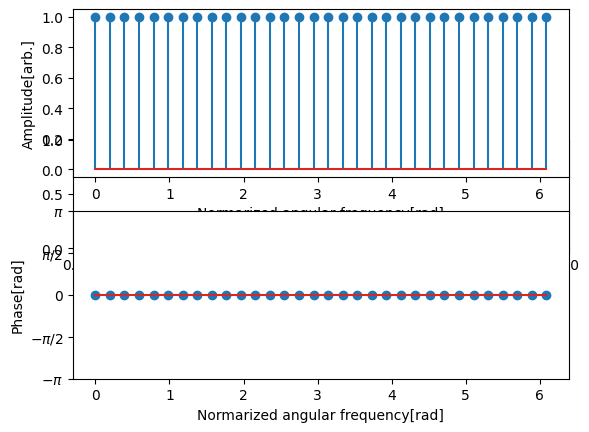

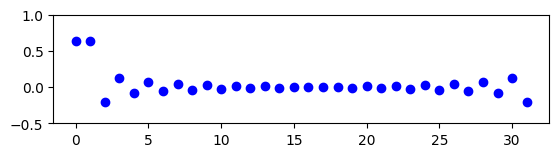

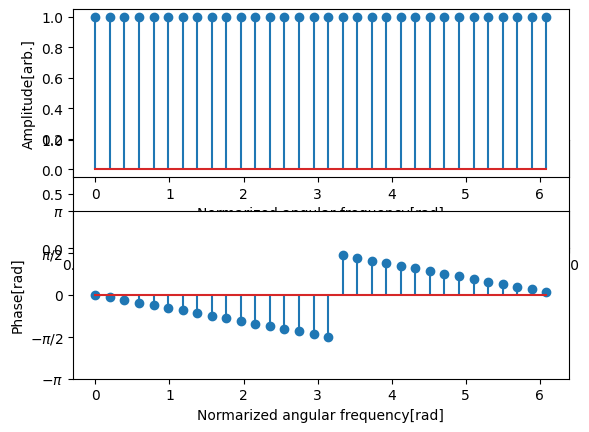

In [103]:
''' インパルス '''
N =  32
fs = None
t = []
unit_pulse = np.append(np.array([1.0]), np.array([0.0 for i in range(N-1)]))
fft_result = np.fft.fft(unit_pulse)

plt.subplot(3,1,1)
plot_wave ( t , unit_pulse, marker = 'o' )
plt.subplot(3,1,2)
plot_FFT_spectrum_ver2(fft_result, fs = fs, real_wave = False)

''' 0.5点遅延 '''
n0 = 0.5
ph = np.array([-2*np.pi*k/N*n0 for k in range(0, int(N/2)+1)])    # 正の周波数領域
ph = np.append(ph, -ph[-2:0:-1])                                  # 負の周波数領域(偏角が正負逆転)
sp_modified = fft_result * np.exp(1j * ph)

unit_pulse_modified = np.real(np.fft.ifft(sp_modified))

plt.subplot(3,1,1)
plot_wave (t ,unit_pulse_modified, marker='o', hold=True)
plt.ylim(-0.5, 1.0)
plt.show()

plt.subplot(3,1,2)
plot_FFT_spectrum_ver2(sp_modified, fs=fs, real_wave=False)

0.5点を遅らせると波形の乱れているように見える。

In [105]:
def wave_htc(t, fft_result, N, f0):
    """
    高調波構造複合音(HCT: Harmonic Complex tone)波形生成
    t           : 時間軸データ
    fft_result  : FFT結果
    N           : FFT次数
    f0          : 基本周波数
    """
    order = int(N/2)                                                    # ナイキスト周波数に対応する次数
    sum = np.zeros(len(t))
    sum = np.real(fft_result[0])                                        # 直流成分
    sum += np.real(fft_result[order]*np.exp(1j*2*np.pi*(order*f0)*t))   # ナイキスト周波数成分を加算
    for n in range(1, order): # 高調波成分
        component = fft_result[n]*np.exp(1j*2*np.pi*(n*f0)*t) \
                    + fft_result[N-n]*np.exp(1j*2*np.pi*(-n*f0)*t)      # 第n高調波を計算
        sum += np.real(component)                                       # 第n高調波を加算
    return(sum/N)

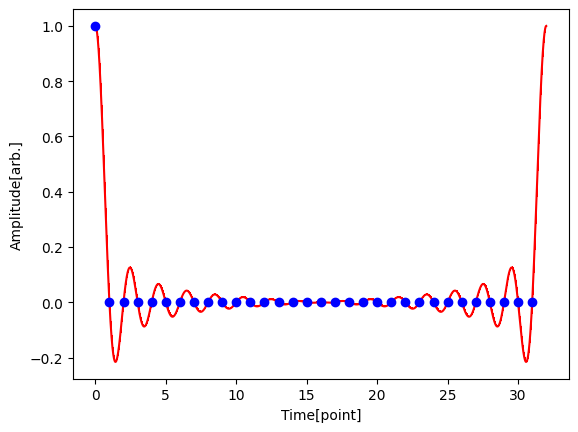

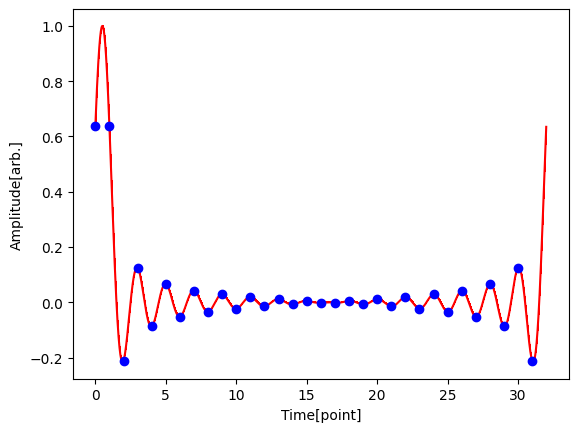

In [106]:
# アナログ波形(疑似)
fs_a = 1000
t_a = np.arange(0, N, 1/fs_a)

# 単位パルス
fn_a = wave_htc(t_a, fft_result, N, f0=1.0/N)
plot_wave(t_a, fn_a, color='r', hold = True)
plot_wave(t, unit_pulse, marker = 'o')

# 0.5点だけ時間推移させた単位パルス
fn_a = wave_htc(t_a, sp_modified, N, f0=1.0/N)
plot_wave(t_a, fn_a, color='r', hold = True)
plot_wave(t, unit_pulse_modified, marker = 'o')

波形がインパルスではなくなることがわかる。アナログ波形を描き、標本化された点と重ねて表示しすると、単位パルスの背景にあるアナログ波形が見える。それを見ると、0.5点遅延させた場合の波形の乱れが乱れでなく、背景にあるアナログ時間波形が時間推移しているだけであることが分かる。